# Post Feature Selection Time Series Analysis and Cross-Validation

### Methods:

Based on the results we found in the previous notebook `_ADP_Feature_Selection.ipynb`, I will fit two models (ARIMAX and linear regression). See the performance results of the various linear regressions modeling below:


| Regressors | $R^2$ | In Sample MAE | Out of Sample MAE|Significance $\alpha$ = 0.05|
|------------|-------|---------------|------------------|------------|
|['Year','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] | 0.810 | 75.82 | 190.5 |No|
|['Date_Rank','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] | 0.888 | 58.80 | 83.02 |No|
|['Date_Rank','admission_count', 'dis_lag1','adp_lag4'] | 0.872 | 59.77 | 98.85 |Yes|
|['Date_Rank','adp_lag4','admission_count']|0.802|70.38|63.58|Yes|
|['sqrt_Date_Rank','adp_lag4','admit_lag3']|0.759|86.49|85.86|Yes|
|['sqrt_Date_Rank','adp_lag4','admission_count']|0.707|96.78|200.2|Yes|
|['sqrt_Date_Rank','adp_lag4','admission_count']|0.690|93.97|178.8|No|

Considerations:

- small sample size: Due to the small sample sizes during model fit, it is difficult to definitely deduce statistically significant relationships between DV and IVs. We should limit the number of regressors and therefore pick the models with a maximum of three IVs.

- Based on the results above, the regression with input variables ['Date_Rank','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] has the rightest r-square value. This is probably due to overfitting (which you can see based on the increased out of sample error) and therefore we will not pick this model. 

- Based on the results above, the regression with input variables ['Date_Rank','admission_count', 'adp_lag4'] has the lowest out of sample average absolute error. I am willing to compromise for the decreased in sample performance as compared to the other models as it ensures we are not overfitting to our training data. However, since we do not know the admission count for the next 12 timestamps, we will also need to predict this in order to predict ADP using the regression model. Also another consideration is that we know ADP will not grow infinitely with time (which is what this function assumes with a linear relation with time). This will most likely cause higher prediction values that will actually occur.

- I also lean towards using the model with input variables of ['sqrt_Date_Rank','adp_lag4','admission_count'] despite the r-square and out of sample MAE not being optimal because I know that the relationship between time and ADP is not fully linear. There is an absolute maximum number of individuals that can be in DOC custody therefore using a non-linear variable makes the most sense as we increase the size of our data sample. This method also forces us to have to predict admission counts into the future but since we will be using the third time lag of admission rates, the first three data points of our prediction will be more accurate than the model mentioned in the above bullet since these are observable values as opposed to predictions.

Therefore, I will consider the following regressors for my linear regression models:

1. ['Date_Rank','adp_lag4','admission_count']

2. ['sqrt_Date_Rank','adp_lag4','admission_count']

3. ['sqrt_Date_Rank','adp_lag4','admit_lag3']

I will also model ADP using two different ARIMA models

1. ARIMA: Analyze ADP timeseries to come up with optimal p, d, q, and seasonal components.

2. ARIMAX: Using the coefficients from ARIMA model 1, I will also input the three time-dependent exogenous variables admission count, discharge count, and length of stay in days to this model

Once I have trained the 4 different models, I look to compare in & out of sample statistics (mean absolute error) and the statistical significance of each IV. I will then use a frequentist approach to construct the CIs, mean and std. dev. of each model and its predictions to guage whether or not my models are reliable and accurate.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import urllib.request
import json
from io import StringIO
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
import pmdarima as pm
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
%matplotlib inline

# Define the functions I will need to quickly retrieve and model data

In [2]:
def check_file_existence(bucket_name,folder_name,file_name):
    """
    Function checks whether or not a specified file exists in its 
    designated location. Returns True if the file exists, otherwise False. 
    """
    try:
        s3_client = boto3.client('s3')
        s3_client.head_object(Bucket=bucket_name, Key=folder_name + file_name)
        return True
    except:
        return False

def get_file(bucket_name,folder_name,file_name): 
    """
    Function checks whether or not a specified file exists in its 
    designated location. If the file exists, the function retreives it from the 
    designated s3 bucket. 
    """
    if check_file_existence(bucket_name,folder_name,file_name):
        try:
            #get the merged file and save as df
            print('Trying to get object from bucket')
            s3_client = boto3.client('s3')
            file_content = s3_client.get_object(Bucket = bucket_name, Key = folder_name + file_name)['Body'].read().decode('utf-8')
            print('Got file contents from AWS S3')
            file_df = pd.read_csv(StringIO(file_content))
            print('Saved file contents as dataframe')
            return file_df
        except Exception as e:
            return e
        
#test functions for the streamlit dashboard
def get_agg_admit_dis_data(first_st_date_adp, api_url, date_col):
    """
    first_st_date_adp: datetime.date
        The date of the first start date 30-day period in the interval data
    api_url: str
        URL of Socrata API endpoint of interest
    date_col: str
        Either date_col or 'DISCHARGED_DT' depending which dataset you are querying from
    """
    if date_col == 'ADMITTED_DT':
        count_col = 'admission_count'

    elif date_col == 'DISCHARGED_DT':
        count_col = 'discharge_count'

    elif date_col != 'ADMITTED_DT' and date_col != 'DISCHARGED_DT':
        print('Date column is not correct and query will not work. Please enter the correct string, either ADMITTED_DT or DISCHARGED_DT.')

    # Define the SQL query separately
    sql_query = ("SELECT "
                f"date_trunc_ymd({date_col}) as {date_col}, "
                f"count(distinct INMATEID) as {count_col} "
                f"WHERE {date_col} >= '{first_st_date_adp}' "
                f"GROUP BY {date_col} "
                "LIMIT 10000")

    # Encode SQL query for URL
    encoded_query = urllib.parse.quote(sql_query)

    # Construct the full URL query
    final_query = f'{api_url}?$query={encoded_query}'
    # Send the request and load the response data
    response = urllib.request.urlopen(final_query)
    data = json.loads(response.read())

    # Store in dataframe
    df = pd.DataFrame(data, columns=data[0].keys())
    #specify data types
    df[date_col] = df[date_col].astype('datetime64[ns]')
    df[count_col] = df[count_col].astype(int)
    #define max and min dates for future calculations
    max_date = df[date_col].max()
    min_date = df[date_col].min()
    #aggregate to 30 day intervals
    # Resample the DataFrame to 30-day intervals
    interval_data = df.resample('30D', on=date_col, origin= min_date, closed='left', label='left').agg({count_col: 'sum'}).fillna(0).reset_index()
    # Rename columns
    interval_data = interval_data.rename(columns={date_col: 'Start Date', count_col: count_col})
    # Calculate the Start Date column
    interval_data['End Date'] = interval_data['Start Date'] + pd.to_timedelta(29, unit='D')
    #add date related regressors
    interval_data['Month'] = interval_data['Start Date'].dt.month
    interval_data['Year'] = interval_data['Start Date'].dt.year
    #calculate the days between start period and last date in admission df
    interval_data['Days to Max Date'] = (max_date - interval_data['Start Date']).dt.days
    # Display just the date portion of the start/end date columns and localize to specific timezone
    interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York').dt.date
    interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York').dt.date
    
    #make sure the last data point has a reasonable admission count
    #if the period has less than 30 days of admission data, we will use the avg of the last two data points
    #as the adjusted admission count for the given time period

    adj_count = []
    for i, row in interval_data.iterrows():
        if row['Days to Max Date'] < 30:
            ma2 = (interval_data.iloc[i-1,interval_data.columns.get_loc(count_col)] +
                        interval_data.iloc[i-2,interval_data.columns.get_loc(count_col)]) / 2
            adj_count.append(round(ma2))
        else:
            adj_count.append(row[count_col])
    #clean up to column name for final dataframe
    final_col_name = ' '.join([word.capitalize() for word in count_col.split('_')])
    interval_data['Adjusted '+final_col_name] = adj_count
    
    _30_day_admit_dis_df = interval_data.drop(columns = count_col)
    
    return _30_day_admit_dis_df

#test functions for the streamlit dashboard
def get_los_data(first_st_date_adp):
    """
    first_st_date_adp: datetime.date
        The date of the first start date 30-day period in the interval data
    """
    dis_url = 'https://data.cityofnewyork.us/resource/94ri-3ium.json'

    dis_query = ("SELECT "
                "distinct INMATEID, "
                "ADMITTED_DT, "
                "DISCHARGED_DT "
                f"WHERE DISCHARGED_DT >= '{first_st_date_adp}' "
                f"GROUP BY INMATEID, ADMITTED_DT, DISCHARGED_DT "
                "LIMIT 1000000")

    # Encode SQL query for URL
    encoded_query = urllib.parse.quote(dis_query)

    # Construct the full URL query
    final_dis_query = f'{dis_url}?$query={encoded_query}'
    print(final_dis_query)

    # Send the request and load the response data
    response = urllib.request.urlopen(final_dis_query)
    data = json.loads(response.read())

    # Store in dataframe
    dis_df = pd.DataFrame(data, columns=data[0].keys())
    
    #specify data types before join
    dis_df[['ADMITTED_DT','DISCHARGED_DT']] = dis_df[['ADMITTED_DT','DISCHARGED_DT']].astype('datetime64[ns]')
    dis_df['INMATEID'] = dis_df['INMATEID'].astype(int)

    dis_df['LOS'] = (dis_df['DISCHARGED_DT'] - dis_df['ADMITTED_DT']).dt.days
    
    #define max and min dates for future calculations
    max_date = dis_df['DISCHARGED_DT'].max()
    min_date = dis_df['DISCHARGED_DT'].min()
    #aggregate to 30 day intervals
    # Resample the DataFrame to 30-day intervals
    interval_data = dis_df.resample('30D', on='DISCHARGED_DT', origin= min_date, closed='left', label='left').agg({'LOS': 'mean'}).fillna(0).reset_index()
    # Rename columns
    interval_data = interval_data.rename(columns={'DISCHARGED_DT': 'Start Date', 'LOS': 'Avg LOS Days'})
    # Calculate the Start Date column
    interval_data['End Date'] = interval_data['Start Date'] + pd.to_timedelta(29, unit='D')
    #add date related regressors
    interval_data['Discharge Month'] = interval_data['Start Date'].dt.month
    interval_data['Discharge Year'] = interval_data['Start Date'].dt.year
    #calculate the days between start period and last date in admission df
    interval_data['Days to Max Date'] = (max_date - interval_data['Start Date']).dt.days
    # Display just the date portion of the start/end date columns and localize to specific timezone
    interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York').dt.date
    interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York').dt.date
    
    #make sure the last data point has a reasonable admission count
    #if the period has less than 30 days of admission data, we will use the avg of the last two data points
    #as the adjusted admission count for the given time period

    adj_count = []
    for i, row in interval_data.iterrows():
        if row['Days to Max Date'] < 30:
            ma2 = (interval_data.iloc[i-1,interval_data.columns.get_loc('Avg LOS Days')] +
                        interval_data.iloc[i-2,interval_data.columns.get_loc('Avg LOS Days')]) / 2
            adj_count.append(round(ma2))
        else:
            adj_count.append(round(row['Avg LOS Days']))
    
    interval_data['Adjusted Avg LOS Days'] = adj_count
    
    _30_day_los_df = interval_data.drop(columns = ['Avg LOS Days','Days to Max Date'])
    
    return _30_day_los_df

def fit_scale_linear_reg(final_df,regressor_ls):
    # Scale the entire dataset
    sc = MinMaxScaler()
    data = final_df[['ADP'] + regressor_ls]
    data_sc = sc.fit_transform(data)

    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=data.columns)

    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    #train test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    #train and test
    # Fit the linear regression model on the entire dataset
    model = sm.OLS(y_train, X_train).fit()

    # Make in sample predictions
    IS_pred = model.predict(X_train)
    # Make out of  sample predictions
    OS_pred = model.predict(X_test)

    #inverse scale the model inputs to get IS predicts
    IS_inputs = pd.concat([IS_pred,X_train.drop(columns=['const'])],axis = 1)
    IS_inputs = IS_inputs.rename(columns={0:'ADP'})
    IS_inputs = sc.inverse_transform(IS_inputs)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X_test.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #accuracy in terms of non-scaled values
    IS_mae = mean_absolute_error(data.iloc[:train_size]['ADP'], IS_inputs[:,0])

    # Make out of  sample predictions
    OS_mae = mean_absolute_error(data.iloc[train_size:]['ADP'], OS_inputs[:,0])

    print('The in sample MAE:', IS_mae)
    print('The out of sample MAE:', OS_mae)
    print(model.summary())

    fig = plt.figure(figsize=(10,5))
    fig.suptitle(f'Linear Regression Model Training')

    actual, = plt.plot(data.index,data['ADP'], 'bo-', label='Actual Data')
    predicted_IS, = plt.plot(data.iloc[:train_size].index, IS_inputs[:,0], 'go-', label='Predicted In Sample')
    predicted_OS, = plt.plot(data.iloc[train_size:].index, OS_inputs[:,0], 'ro-', label='Predicted Out of Sample')

    plt.legend(handles=[actual,predicted_IS,predicted_OS])
    plt.show()

    return model, IS_mae, OS_mae

# Now lets get our DV & IVs

In [3]:
bucket_name = 'doc-daily-inmates-in-custody'
folder_name = 'data/merged_files/'
file_name = 'agg_daily_pop.csv'

adp_df = get_file(bucket_name, folder_name, file_name)
#aggregate to 30 day intervals
#set data type
adp_df['snapshot_date'] = pd.to_datetime(adp_df['snapshot_date'])
#get latest snapshot date
max_date = adp_df['snapshot_date'].max()
#aggregate to 30 day periods
interval_data = adp_df.resample('30D', on='snapshot_date',origin = max_date,closed='right',label = 'right').mean().round().fillna(0).reset_index()
interval_data = interval_data.rename(columns = {'snapshot_date':'End Date','Total Population':'ADP'})
interval_data['Start Date'] = interval_data['End Date'] - pd.to_timedelta(29, unit='D')

#display just date of the start/end date columns localize to specific timezone or altar will assume UTC in graph
interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York')
interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York')

#lets only look at the total population
_30day_pop_tot = interval_data[['Start Date','End Date','ADP']]
_30day_pop_tot['adp_lag4'] = _30day_pop_tot['ADP'].shift(4).fillna(0)
_30day_pop_tot.head()


Trying to get object from bucket
Got file contents from AWS S3
Saved file contents as dataframe


C:\Users\emjoh\AppData\Local\Temp\ipykernel_28176\1988439935.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _30day_pop_tot['adp_lag4'] = _30day_pop_tot['ADP'].shift(4).fillna(0)


,Start Date,End Date,ADP,adp_lag4
0,2021-07-20 00:00:00-04:00,2021-08-18 00:00:00-04:00,5925.0,0.0
1,2021-08-19 00:00:00-04:00,2021-09-17 00:00:00-04:00,6033.0,0.0
2,2021-09-18 00:00:00-04:00,2021-10-17 00:00:00-04:00,5749.0,0.0
3,2021-10-18 00:00:00-04:00,2021-11-16 00:00:00-05:00,5518.0,0.0
4,2021-11-17 00:00:00-05:00,2021-12-16 00:00:00-05:00,5408.0,5925.0


In [4]:
_30day_pop_tot.tail()

,Start Date,End Date,ADP,adp_lag4
27,2023-10-08 00:00:00-04:00,2023-11-06 00:00:00-05:00,6179.0,6085.0
28,2023-11-07 00:00:00-05:00,2023-12-06 00:00:00-05:00,6149.0,6175.0
29,2023-12-07 00:00:00-05:00,2024-01-05 00:00:00-05:00,6044.0,6191.0
30,2024-01-06 00:00:00-05:00,2024-02-04 00:00:00-05:00,6139.0,6186.0
31,2024-02-05 00:00:00-05:00,2024-03-05 00:00:00-05:00,6226.0,6179.0


In [5]:
admit_url = 'https://data.cityofnewyork.us/resource/6teu-xtgp.json'
dis_url = 'https://data.cityofnewyork.us/resource/94ri-3ium.json'
first_st_date_adp = _30day_pop_tot.iloc[0]['Start Date'].date()
admit_df = get_agg_admit_dis_data(first_st_date_adp, admit_url, 'ADMITTED_DT')
dis_df = get_agg_admit_dis_data(first_st_date_adp, dis_url, 'DISCHARGED_DT')

print(admit_df.head())
print()
print(admit_df.tail())
print()
print(dis_df.head())
print()
print(dis_df.tail())


   Start Date    End Date  ...  Days to Max Date  Adjusted Admission Count
0  2021-07-20  2021-08-18  ...               954                      1520
1  2021-08-19  2021-09-17  ...               924                      1446
2  2021-09-18  2021-10-17  ...               894                      1273
3  2021-10-18  2021-11-16  ...               864                      1229
4  2021-11-17  2021-12-16  ...               834                      1328

[5 rows x 6 columns]

    Start Date    End Date  ...  Days to Max Date  Adjusted Admission Count
27  2023-10-08  2023-11-06  ...               144                      1826
28  2023-11-07  2023-12-06  ...               114                      1753
29  2023-12-07  2024-01-05  ...                84                      1563
30  2024-01-06  2024-02-04  ...                54                      1879
31  2024-02-05  2024-03-05  ...                24                      1721

[5 rows x 6 columns]

   Start Date    End Date  ...  Days to Max Date

In [6]:
#test los function
los_df = get_los_data(first_st_date_adp)
los_df.head()

https://data.cityofnewyork.us/resource/94ri-3ium.json?$query=SELECT%20distinct%20INMATEID%2C%20ADMITTED_DT%2C%20DISCHARGED_DT%20WHERE%20DISCHARGED_DT%20%3E%3D%20%272021-07-20%27%20GROUP%20BY%20INMATEID%2C%20ADMITTED_DT%2C%20DISCHARGED_DT%20LIMIT%201000000


,Start Date,End Date,Discharge Month,Discharge Year,Adjusted Avg LOS Days
0,2021-07-20,2021-08-18,7,2021,128
1,2021-08-19,2021-09-17,8,2021,108
2,2021-09-18,2021-10-17,9,2021,110
3,2021-10-18,2021-11-16,10,2021,110
4,2021-11-17,2021-12-16,11,2021,120


In [7]:
#rename column names in both dfs
admit_df = admit_df.rename(columns = {'Adjusted Admission Count': 'admission_count'})
admit_df = admit_df.drop(columns = ['Days to Max Date','Year','Month'])
dis_df = dis_df.rename(columns = {'Adjusted Discharge Count': 'discharge_count'})
dis_df = dis_df.drop(columns = ['Days to Max Date','Year','Month'])
los_df = los_df.rename(columns = {'Adjusted Avg LOS Days': 'los_days'})
los_df = los_df.drop(columns = ['Discharge Year', 'Discharge Month'])   

admit_df['admit_lag3'] = admit_df['admission_count'].shift(3).fillna(0)

In [8]:
#specify data types for join
admit_df['Start Date'] = admit_df['Start Date'].astype('datetime64[ns, America/New_York]')
admit_df['End Date'] = admit_df['End Date'].astype('datetime64[ns, America/New_York]')

dis_df['Start Date'] = dis_df['Start Date'].astype('datetime64[ns, America/New_York]')
dis_df['End Date'] = dis_df['End Date'].astype('datetime64[ns, America/New_York]')


los_df['Start Date'] = los_df['Start Date'].astype('datetime64[ns, America/New_York]')
los_df['End Date'] = los_df['End Date'].astype('datetime64[ns, America/New_York]')

adm_dis_merge = admit_df.merge(dis_df, how = 'inner', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])
adm_dis_merge = adm_dis_merge.merge(los_df, how = 'left', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])
_30day_pop_tot = _30day_pop_tot.merge(adm_dis_merge, how = 'left', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])

#finally lets add a unique id for month-year ranks from earliest to latest date
#in a regression these variables will mimic a linear trend of x, where x is a positive integer (our proxy for time)
_30day_pop_tot['Date_Rank'] = _30day_pop_tot.sort_values(by = 'Start Date').index
_30day_pop_tot['sqrt_Date_Rank'] = np.sqrt(_30day_pop_tot['Date_Rank'])
_30day_pop_tot.head()

,Start Date,End Date,ADP,adp_lag4,admission_count,admit_lag3,discharge_count,los_days,Date_Rank,sqrt_Date_Rank
0,2021-07-20 00:00:00-04:00,2021-08-18 00:00:00-04:00,5925.0,0.0,1520,0.0,1437,128,0,0.000000
1,2021-08-19 00:00:00-04:00,2021-09-17 00:00:00-04:00,6033.0,0.0,1446,0.0,1343,108,1,1.000000
2,2021-09-18 00:00:00-04:00,2021-10-17 00:00:00-04:00,5749.0,0.0,1273,0.0,1665,110,2,1.414214
3,2021-10-18 00:00:00-04:00,2021-11-16 00:00:00-05:00,5518.0,0.0,1229,1520.0,1379,110,3,1.732051
4,2021-11-17 00:00:00-05:00,2021-12-16 00:00:00-05:00,5408.0,5925.0,1328,1446.0,1343,120,4,2.000000


# Linear Regressions

Two models:

1. ['Date_Rank','adp_lag4','admission_count']

2. ['sqrt_Date_Rank','adp_lag4','admit_lag3']

Performance Measures:

1. r-Square, In sample MAE

2. Out of Sample MAE

Forecasts:

Once both models are trained and defined, I will forecast the next 12 periods. Admission count will need to be predicted for each forecast, but we already dictated the coefficients that best fit the 30-day admission count in `ADP_linear_reg.ipynb`. Therefore we will predict the 30-day admission counts using order = (0,1,1) and seasonal_order = (1,0,0,12).

The in sample MAE: 78.59846647871153
The out of sample MAE: 64.51661983413331
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     25.26
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           3.66e-07
Time:                        09:09:51   Log-Likelihood:                 16.503
No. Observations:                  25   AIC:                            -25.01
Df Residuals:                      21   BIC:                            -20.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

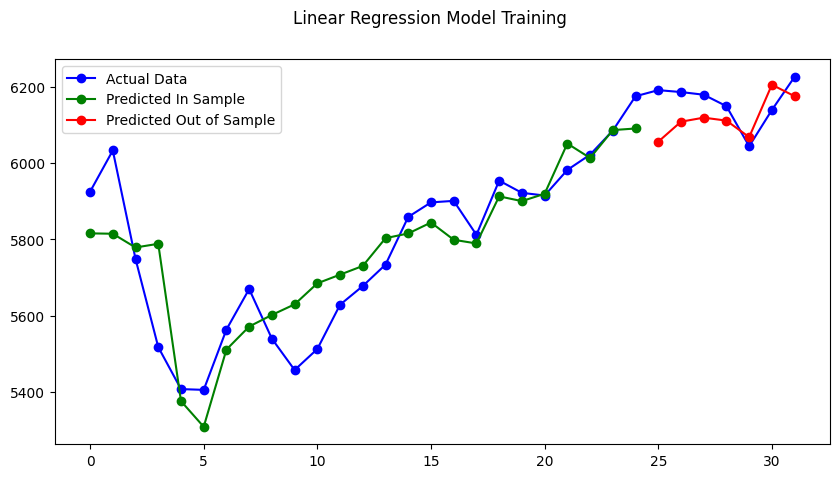

In [9]:
#step 1 fit and test each model

model_1, IS_mae_1, OS_mae_1 = fit_scale_linear_reg(_30day_pop_tot,['Date_Rank','adp_lag4','admission_count'])


The in sample MAE: 98.31877887386432
The out of sample MAE: 77.20556430434355
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     15.39
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           1.60e-05
Time:                        09:09:51   Log-Likelihood:                 11.939
No. Observations:                  25   AIC:                            -15.88
Df Residuals:                      21   BIC:                            -11.00
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

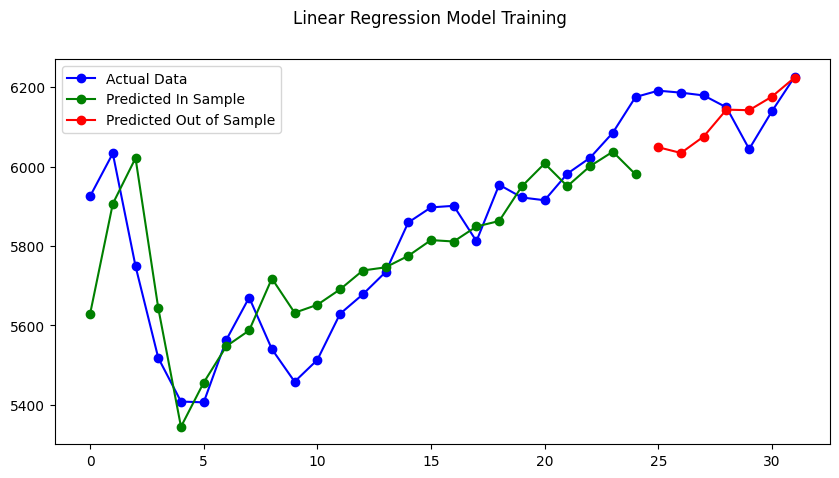

In [10]:
model_2, IS_mae_2, OS_mae_2 = fit_scale_linear_reg(_30day_pop_tot,['sqrt_Date_Rank','adp_lag4','admit_lag3'])

The in sample MAE: 98.67391836417595
The out of sample MAE: 200.07215738643066
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     16.07
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           1.17e-05
Time:                        09:09:51   Log-Likelihood:                 12.312
No. Observations:                  25   AIC:                            -16.62
Df Residuals:                      21   BIC:                            -11.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

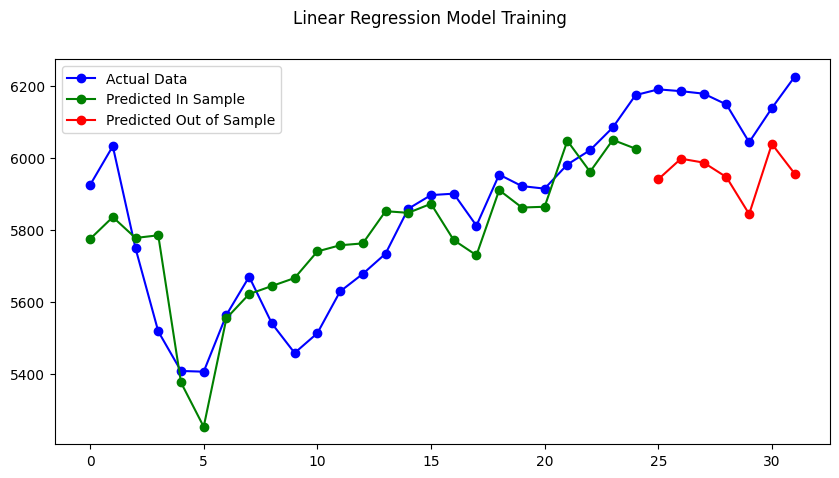

In [11]:
model_3, IS_mae_3, OS_mae_3 = fit_scale_linear_reg(_30day_pop_tot,['sqrt_Date_Rank','adp_lag4','admission_count'])

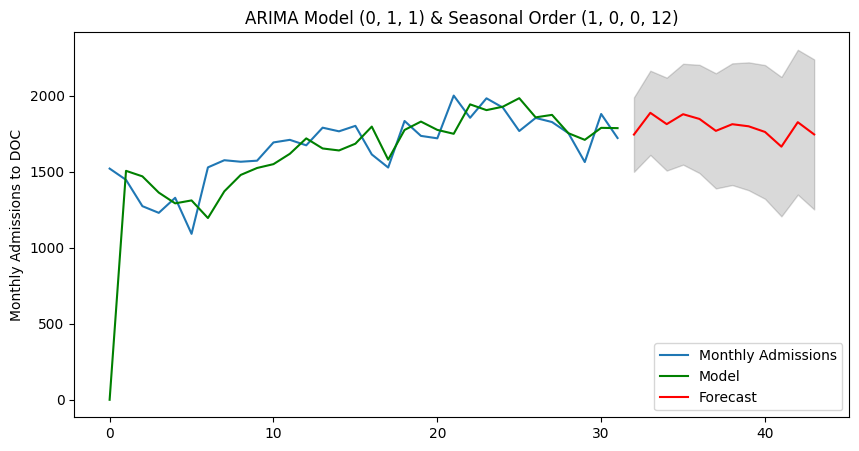

In [12]:
#STEP 2: Forecast. Let's predict 30-day admission counts for 12 future time periods
#fit model to data
p=0
d=1
q=1
order = (p,d,q)
seasonal_order = (1,0,0,12)
#admission count
series = _30day_pop_tot['admission_count']

admit_arima_model = SARIMAX(series, order=order,seasonal_order=seasonal_order)
admit_arima_model_fit = admit_arima_model.fit()
# Perform in-sample predictions
train_predictions = admit_arima_model_fit.predict()
#forecast
pred = admit_arima_model_fit.get_forecast(steps=12)
fc_series = pd.Series(pred.summary_frame()['mean'].values)
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Admissions') # ACTUAL DATA
ax.plot(series.index,train_predictions,color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Monthly Admissions to DOC')
plt.title(f'ARIMA Model {order} & Seasonal Order {seasonal_order}')
plt.legend(loc = 'lower right')
plt.show()

In [13]:
print(admit_arima_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                     admission_count   No. Observations:                   32
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -195.483
Date:                             Wed, 06 Mar 2024   AIC                            396.966
Time:                                     09:09:52   BIC                            401.268
Sample:                                          0   HQIC                           398.368
                                              - 32                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4729      0.193     -2.449      0.014      -0.851      -0.094
ar.S.L12       0.5091      

In [14]:
#predictions for admissions are stored in the below df
fc

admission_count,mean,mean_se,mean_ci_lower,mean_ci_upper
32,1743.591279,124.968303,1498.657906,1988.524652
33,1886.650396,141.266555,1609.773036,2163.527756
34,1812.320748,155.869825,1506.821505,2117.819991
35,1877.486467,169.217508,1545.826245,2209.146689
36,1846.430929,181.586695,1490.527546,2202.334312
37,1768.028424,193.165449,1389.431101,2146.625747
38,1811.811641,204.088347,1411.805831,2211.817451
39,1798.065747,214.455628,1377.740441,2218.391054
40,1760.900923,224.344331,1321.194113,2200.607733
41,1664.170559,233.815187,1205.901213,2122.439905


The `fc['mean']` series will be one of the IVs for model 1. However, model 2 we are using the 3rd time lag of admissions. So we actually need the 3 latest admission counts from `_30day_pop_tot['admission_count']` and the first 9 predictions from `fc['mean']` for the `admit_lag3` IV for model 2.

In [15]:
model1_admission_cnt_IV = fc['mean']
model2_admit_lag3_IV = pd.concat([_30day_pop_tot['admission_count'].iloc[-3:],fc['mean'].iloc[:-3]])
model1_admission_cnt_IV

32    1743.591279
33    1886.650396
34    1812.320748
35    1877.486467
36    1846.430929
37    1768.028424
38    1811.811641
39    1798.065747
40    1760.900923
41    1664.170559
42    1825.048428
43    1744.609493
Name: mean, dtype: float64

In [16]:
model2_admit_lag3_IV

29    1563.000000
30    1879.000000
31    1721.000000
32    1743.591279
33    1886.650396
34    1812.320748
35    1877.486467
36    1846.430929
37    1768.028424
38    1811.811641
39    1798.065747
40    1760.900923
dtype: float64

Forecast for model 1. We need to create regressors for adp_lag4 and Date_Rank in addition to the admission_count defined above.

In [17]:
#define sc of the data for the use on regressors
#select only relevant data
final_df = _30day_pop_tot[['ADP','Date_Rank','adp_lag4','admission_count']]
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m1 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m1['Date_Rank'] = np.arange(len(final_df),len(final_df)+12)
#store admission predictions
forecast_regressors_m1['admission_count'] = model1_admission_cnt_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m1.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m1.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m1.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_1.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m1.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m1.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_1 = forecast_regressors_m1['ADP']
forecast_regressors_m1

,ADP,Date_Rank,adp_lag4,admission_count
0,6210.770083,32,6149.0,1744.0
1,6294.868698,33,6044.0,1887.0
2,6285.965916,34,6139.0,1812.0
3,6327.189901,35,6226.0,1877.0
4,6342.626006,36,6210.770083,1846.0
5,6333.531564,37,6294.868698,1768.0
6,6374.975467,38,6285.965916,1812.0
7,6391.921689,39,6327.189901,1798.0
8,6402.792797,40,6342.626006,1761.0
9,6394.4093,41,6333.531564,1664.0


In [18]:
#define sc of the data for the use on regressors
#select only relevant data
final_df = _30day_pop_tot[['ADP','sqrt_Date_Rank','adp_lag4','admit_lag3']]
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m2 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m2['sqrt_Date_Rank'] = np.sqrt(np.arange(len(final_df),len(final_df)+12))
#store admission predictions
forecast_regressors_m2['admit_lag3'] = model2_admit_lag3_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m2.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m2.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m2.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_2.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m2.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m2.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_2 = forecast_regressors_m2['ADP']
forecast_regressors_m2

,ADP,sqrt_Date_Rank,adp_lag4,admit_lag3
0,6308.946154,5.656854,6149.0,1563.0
1,6243.429852,5.744563,6044.0,1879.0
2,6309.509555,5.830952,6139.0,1721.0
3,6320.27858,5.916080,6226.0,1744.0
4,6294.190869,6.000000,6308.946154,1887.0
5,6344.544153,6.082763,6243.429852,1812.0
6,6342.86889,6.164414,6309.509555,1877.0
7,6374.028,6.244998,6320.27858,1846.0
8,6421.775835,6.324555,6294.190869,1768.0
9,6426.734487,6.403124,6344.544153,1812.0


Let's plot the forecasts of both models!

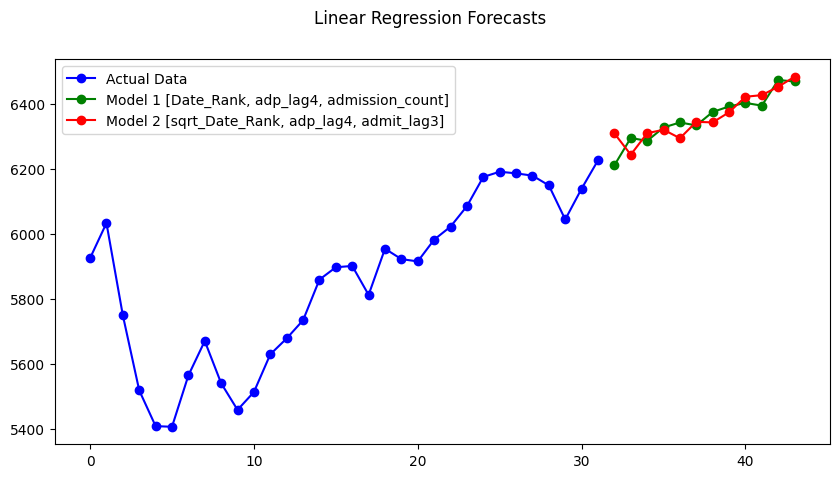

In [19]:
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Linear Regression Forecasts')

actual, = plt.plot(final_df.index,final_df['ADP'], 'bo-', label='Actual Data')
forecast_m1, = plt.plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m1['ADP'],
                        'go-', label='Model 1 [Date_Rank, adp_lag4, admission_count]')
forecast_m2, = plt.plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m2['ADP'],
                        'ro-', label='Model 2 [sqrt_Date_Rank, adp_lag4, admit_lag3]')

plt.legend(handles=[actual,forecast_m1,forecast_m2])
plt.show()

Plot the model and the forecasts for each model side by side

In [20]:
#fit each model to the entire data set
# Scale the entire dataset
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP','Date_Rank','adp_lag4','admission_count']]

data_sc = sc.fit_transform(data)

# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)

# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X_model1 = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

# Make in sample predictions
# Fit the linear regression model on the entire dataset
model_1 = sm.OLS(y, X_model1).fit()
IS_pred_model1 = model_1.predict(X_model1)

#inverse scale the model inputs to get IS predicts
IS_inputs_model1 = pd.concat([IS_pred_model1,X_model1.drop(columns=['const'])],axis = 1)
IS_inputs_model1 = IS_inputs_model1.rename(columns={0:'ADP'})
IS_inputs_model1 = sc.inverse_transform(IS_inputs_model1)

#accuracy in terms of non-scaled values
IS_mae_model1 = mean_absolute_error(data['ADP'], IS_inputs_model1[:,0])

print('The in sample MAE for model 1:', IS_mae_model1)
print(model_1.summary())

The in sample MAE for model 1: 73.5115730998204
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     55.47
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           6.66e-12
Time:                        09:09:52   Log-Likelihood:                 23.269
No. Observations:                  32   AIC:                            -38.54
Df Residuals:                      28   BIC:                            -32.68
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [21]:
#forecast
#define sc of the data for the use on regressors
final_df = data
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m1 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m1['Date_Rank'] = np.arange(len(final_df),len(final_df)+12)
#store admission predictions
forecast_regressors_m1['admission_count'] = model1_admission_cnt_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m1.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m1.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m1.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_1.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m1.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m1.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_1 = forecast_regressors_m1['ADP']
forecast_regressors_m1

,ADP,Date_Rank,adp_lag4,admission_count
0,6240.66159,32,6149.0,1744.0
1,6324.210196,33,6044.0,1887.0
2,6317.781275,34,6139.0,1812.0
3,6359.353703,35,6226.0,1877.0
4,6374.331937,36,6240.66159,1846.0
5,6367.818442,37,6324.210196,1768.0
6,6409.8766,38,6317.781275,1812.0
7,6428.418921,39,6359.353703,1798.0
8,6441.342083,40,6374.331937,1761.0
9,6435.717311,41,6367.818442,1664.0


In [22]:
#fit each model to the entire data set
# Scale the entire dataset
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP','Date_Rank','adp_lag4','admit_lag3']]

data_sc = sc.fit_transform(data)

# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)

# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X_model2 = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

# Make in sample predictions
# Fit the linear regression model on the entire dataset
model_2 = sm.OLS(y, X_model2).fit()
IS_pred_model2 = model_2.predict(X_model2)

#inverse scale the model inputs to get IS predicts
IS_inputs_model2 = pd.concat([IS_pred_model2,X_model2.drop(columns=['const'])],axis = 1)
IS_inputs_model2 = IS_inputs_model2.rename(columns={0:'ADP'})
IS_inputs_model2 = sc.inverse_transform(IS_inputs_model2)

#accuracy in terms of non-scaled values
IS_mae_model2 = mean_absolute_error(data['ADP'], IS_inputs_model2[:,0])

print('The in sample MAE for model 2:', IS_mae_model2)
print(model_2.summary())

The in sample MAE for model 2: 81.80780881446387
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     55.14
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           7.16e-12
Time:                        09:09:53   Log-Likelihood:                 23.186
No. Observations:                  32   AIC:                            -38.37
Df Residuals:                      28   BIC:                            -32.51
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Dat

In [23]:
#forecast
#define sc of the data for the use on regressors
#select only relevant data
final_df = _30day_pop_tot[['ADP','sqrt_Date_Rank','adp_lag4','admit_lag3']]
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m2 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m2['sqrt_Date_Rank'] = np.sqrt(np.arange(len(final_df),len(final_df)+12))
#store admission predictions
forecast_regressors_m2['admit_lag3'] = model2_admit_lag3_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m2.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m2.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m2.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_2.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m2.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m2.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_2 = forecast_regressors_m2['ADP']
forecast_regressors_m2

,ADP,sqrt_Date_Rank,adp_lag4,admit_lag3
0,6364.699156,5.656854,6149.0,1563.0
1,6327.70055,5.744563,6044.0,1879.0
2,6369.969394,5.830952,6139.0,1721.0
3,6378.41249,5.916080,6226.0,1744.0
4,6361.681774,6.000000,6364.699156,1887.0
5,6393.857287,6.082763,6327.70055,1812.0
6,6395.833112,6.164414,6369.969394,1877.0
7,6417.192261,6.244998,6378.41249,1846.0
8,6448.345566,6.324555,6361.681774,1768.0
9,6454.124315,6.403124,6393.857287,1812.0


In [24]:
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP','sqrt_Date_Rank','adp_lag4','admission_count']]

data_sc = sc.fit_transform(data)

# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)

# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X_model3 = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

# Make in sample predictions
# Fit the linear regression model on the entire dataset
model_3 = sm.OLS(y, X_model3).fit()
IS_pred_model3 = model_3.predict(X_model3)

#inverse scale the model inputs to get IS predicts
IS_inputs_model3 = pd.concat([IS_pred_model3,X_model3.drop(columns=['const'])],axis = 1)
IS_inputs_model3 = IS_inputs_model3.rename(columns={0:'ADP'})
IS_inputs_model3 = sc.inverse_transform(IS_inputs_model3)

#accuracy in terms of non-scaled values
IS_mae_model3 = mean_absolute_error(data['ADP'], IS_inputs_model3[:,0])

print('The in sample MAE for model 2:', IS_mae_model3)
print(model_3.summary())

The in sample MAE for model 2: 92.83591750318223
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     29.86
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           7.20e-09
Time:                        09:09:53   Log-Likelihood:                 15.223
No. Observations:                  32   AIC:                            -22.45
Df Residuals:                      28   BIC:                            -16.58
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [25]:
#forecast
#define sc of the data for the use on regressors
final_df = data
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m3 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m3['sqrt_Date_Rank'] = np.sqrt(np.arange(len(final_df),len(final_df)+12))
#store admission predictions
forecast_regressors_m3['admission_count'] = model1_admission_cnt_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m3.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m3.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m3.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_3.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m3.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m3.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_3 = forecast_regressors_m3['ADP']
forecast_regressors_m3

,ADP,sqrt_Date_Rank,adp_lag4,admission_count
0,6139.124275,5.656854,6149.0,1744.0
1,6223.622281,5.744563,6044.0,1887.0
2,6198.952924,5.830952,6139.0,1812.0
3,6231.659242,5.916080,6226.0,1877.0
4,6243.047761,6.000000,6139.124275,1846.0
5,6217.588426,6.082763,6223.622281,1768.0
6,6252.608075,6.164414,6198.952924,1812.0
7,6258.027521,6.244998,6231.659242,1798.0
8,6256.121059,6.324555,6243.047761,1761.0
9,6233.481989,6.403124,6217.588426,1664.0


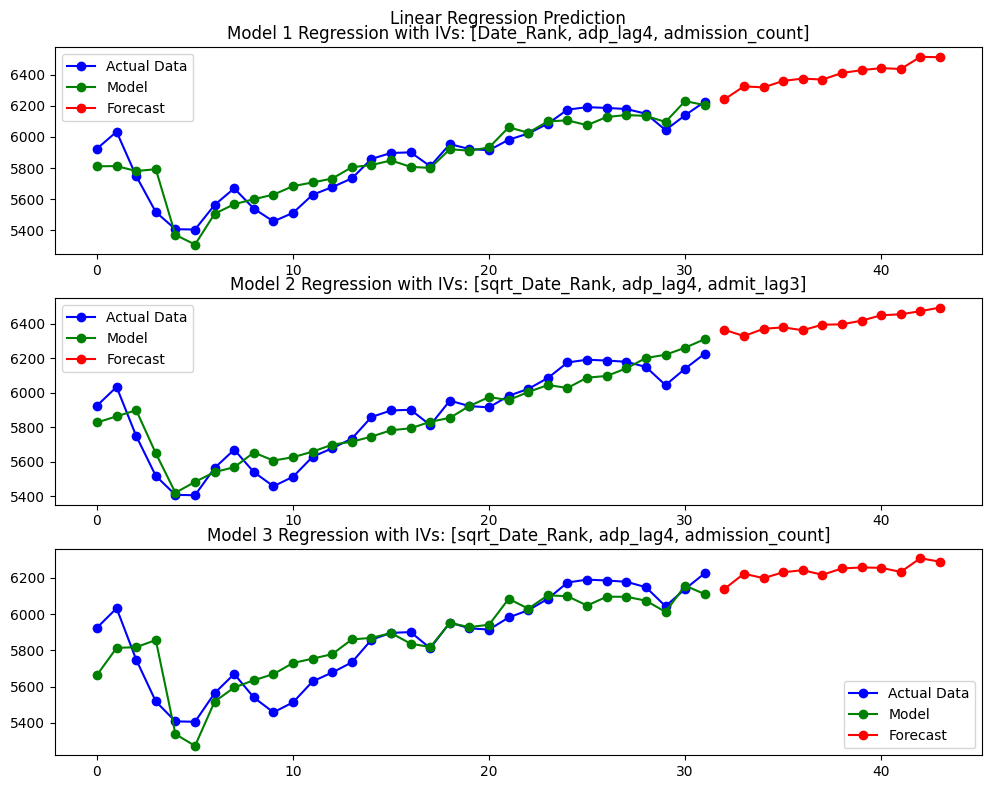

In [26]:
fig, ax = plt.subplots(3,figsize=(10,8))
fig.suptitle(f'Linear Regression Prediction')
fig.tight_layout()

actual, = ax[0].plot(final_df.index,final_df['ADP'], 'bo-', label='Actual Data')
actual, = ax[1].plot(final_df.index,final_df['ADP'], 'bo-', label='Actual Data')
actual, = ax[2].plot(final_df.index,final_df['ADP'], 'bo-', label='Actual Data')
IS_model1, = ax[0].plot(final_df.index, IS_inputs_model1[:,0], 'go-', label='Model')
IS_model2, = ax[1].plot(final_df.index, IS_inputs_model2[:,0], 'go-', label='Model')
IS_model3, = ax[2].plot(final_df.index, IS_inputs_model3[:,0], 'go-', label='Model')

forecast_m1, = ax[0].plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m1['ADP'],
                        'ro-', label='Forecast')
forecast_m2, = ax[1].plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m2['ADP'],
                        'ro-', label='Forecast')
forecast_m3, = ax[2].plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m3['ADP'],
                        'ro-', label='Forecast')

ax[0].set_title('Model 1 Regression with IVs: [Date_Rank, adp_lag4, admission_count]')
ax[1].set_title('Model 2 Regression with IVs: [sqrt_Date_Rank, adp_lag4, admit_lag3]')
ax[2].set_title('Model 3 Regression with IVs: [sqrt_Date_Rank, adp_lag4, admission_count]')

ax[0].legend(handles=[actual,IS_model1, forecast_m1])
ax[1].legend(handles=[actual,IS_model2, forecast_m2])
ax[2].legend(handles=[actual,IS_model3, forecast_m3])
plt.show()

Either of these models will do a decent job predicting our ADP in the future. I tend to have preference for model two because it is estimating lower quantities than model 1 and I don't hypothesize the ADP will continue linearly up into the future at such a rate.

### Part 2: ARIMA Models

model ADP using two different ARIMA models

1. ARIMA: Analyze ADP timeseries to come up with optimal p, d, q, and seasonal components.

2. ARIMAX: Using the coefficients from ARIMA model 1, I will also input the three time-dependent exogenous variables admission count, discharge count, and length of stay in days to this model


In [27]:
#import arima packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss,range_unit_root_test # BDS for inped
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [28]:
#analyze time series
ts = _30day_pop_tot['ADP']

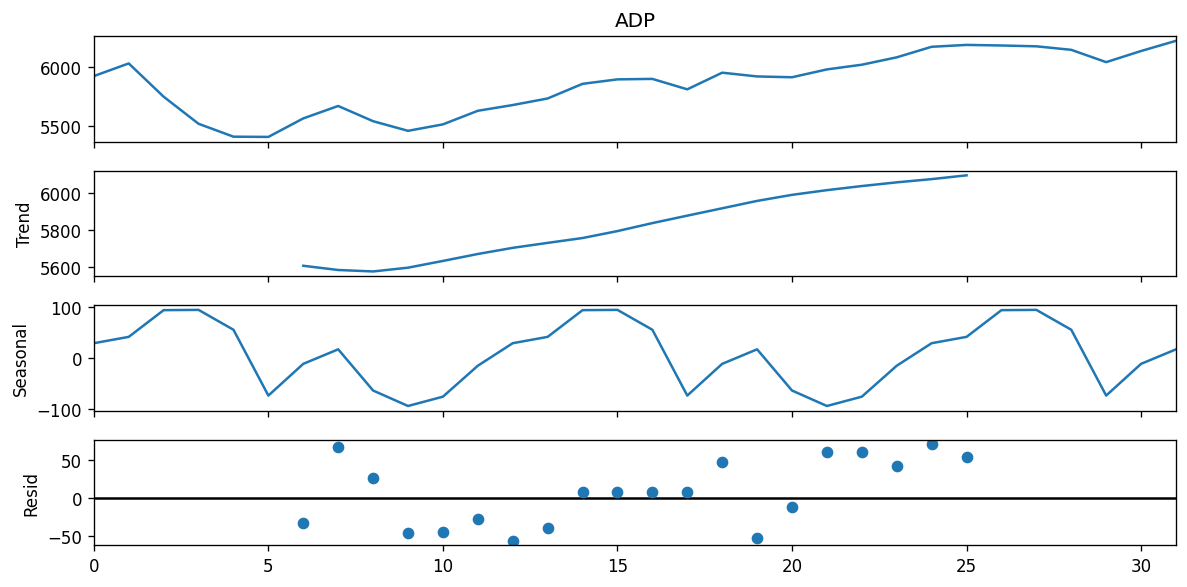

In [29]:
#decompose the monthly admission count
results = seasonal_decompose(ts,model='additive',period=12)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

Determine stationality of ts. Figure out the optimal d coefficient

In [30]:
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.667368
p-value: 0.855022
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


Based on the p-value for the adf test above, the signal is not stationary. Let's determine the differencing order we need to use for our ARIMA model.

In [31]:
result = adfuller(ts.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.991936
p-value: 0.001453
Critical Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621


In [32]:
result = adfuller(ts.diff(2).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.842816
p-value: 0.359422
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636


We took the first difference of the signal to get the p-value below the 0.05. Therefore d = 1. Lets examine the PACF and ACF of the differenced signal to determine the autoregressive and moving average terms.

Text(0.5, 1.0, 'Partial Autocorrelation')

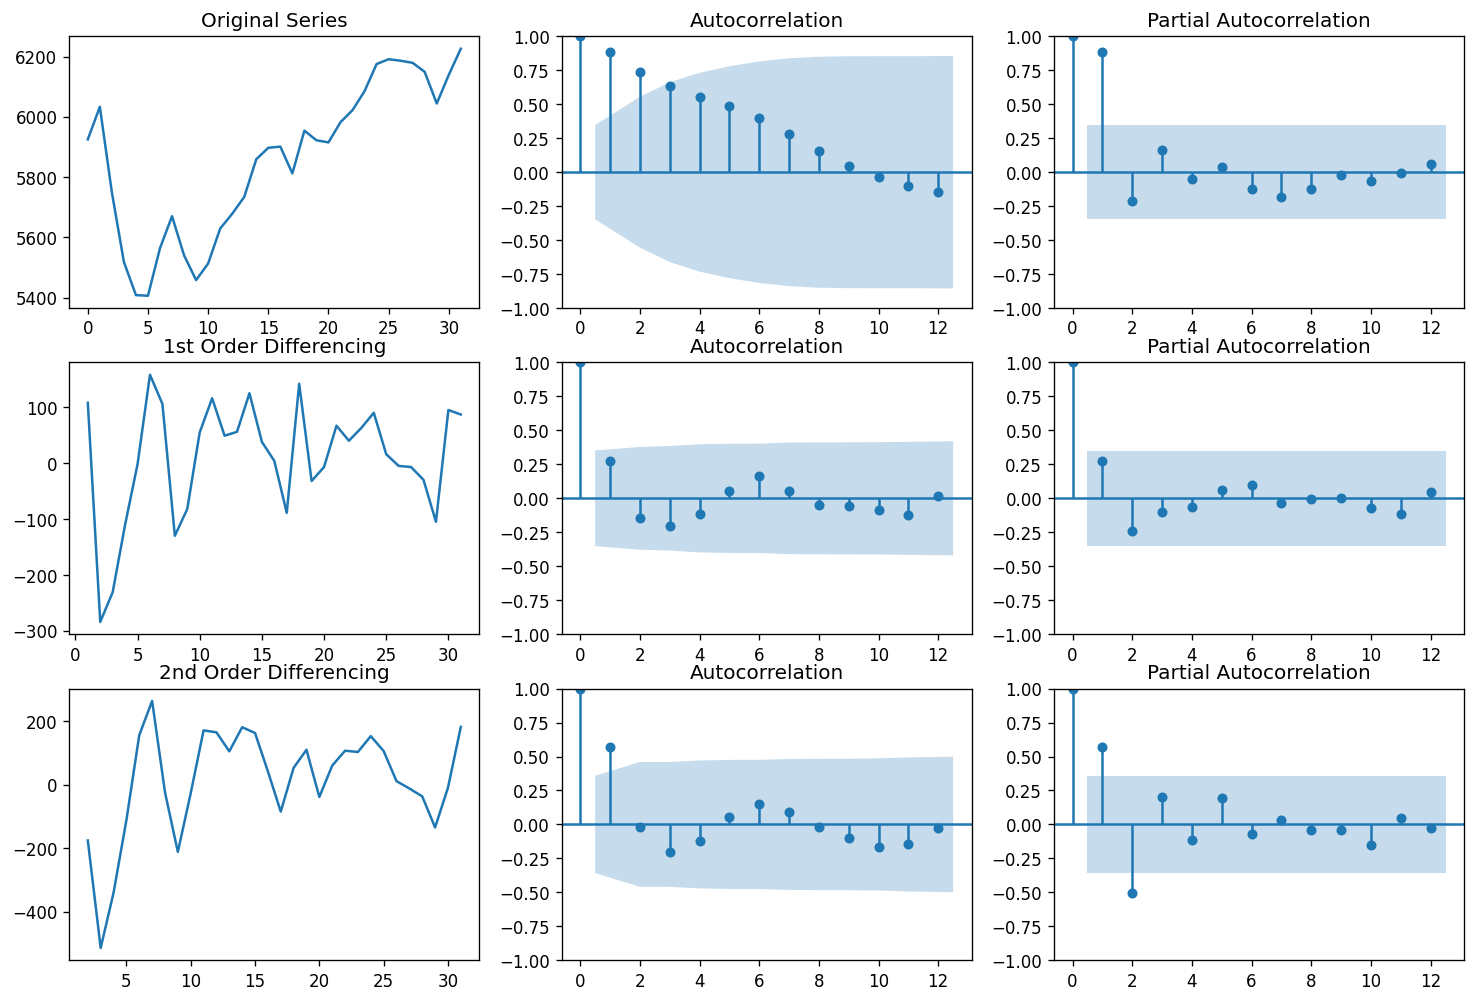

In [33]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')

plot_acf(ts, lags = 12, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(ts, lags = 12, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(ts.diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(ts.diff().dropna(), lags = 12, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(ts.diff().dropna(), lags = 12, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(ts.diff(2)); axes[2, 0].set_title('2nd Order Differencing')

plot_acf(ts.diff(2).dropna(), lags = 12, ax = axes[2, 1])
axes[2, 1].set_title('Autocorrelation')

plot_pacf(ts.diff(2).dropna(), lags = 12, ax=axes[2, 2])
axes[2, 2].set_title('Partial Autocorrelation')

### Rules for identifying the numbers of AR and MA terms:

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

Recall that:

* **q:** The size of the moving average window, or the number of the moving average terms, also called the order of moving average.

* **p:** The number of AR terms included in the model, also called the lag order.

Autoregressive models: AR(p)

moving average models: MA(q)

mixed autoregressive moving average models: ARMA(p, q)

integration models: ARIMA(p, d, q)

seasonal models: SARIMA(P, D, Q, s)

Based on the information above, the PACF of the stationary signal (1st order differencing) has two (borderline) significant lag terms. Therefore, $p = 2$. Lets test an ARIMA(2,1,0) and see how well it fits.

The in sample MAE is:  313.0060344420486
The out of sample MAE is:  41.01376524062055
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   25
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -144.084
Date:                Wed, 06 Mar 2024   AIC                            294.169
Time:                        09:09:56   BIC                            297.703
Sample:                             0   HQIC                           295.106
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5125      0.259      1.982      0.047       0.006       1.019
ar.L2         -0.4761      0.175     -2.726  

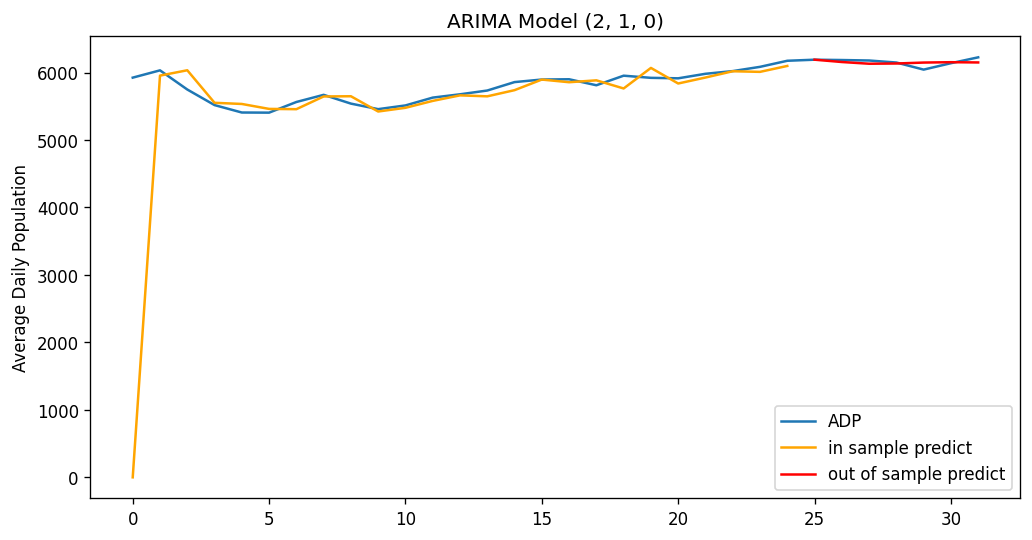

In [34]:
p=2
d=1
q=0
order = (p,d,q)
# fit model
train_size = int(len(ts)*0.8)
#train test split
series_train =  ts.iloc[:train_size]
series_test = ts.iloc[train_size:]

model = SARIMAX(series_train, order=order)
model_fit = model.fit()
IS_pred = model_fit.predict()
pred = model_fit.get_forecast(steps=len(series_test))
IS_mae = mean_absolute_error(series_train, IS_pred)
OS_mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The in sample MAE is: ', IS_mae)
print('The out of sample MAE is: ', OS_mae)
print(model_fit.summary())

#plot
# Perform in-sample predictions
train_predictions = model_fit.predict()
fc_series = pd.Series(pred.summary_frame()['mean'].values)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # train
ax.plot(series_train.index,train_predictions,color='orange',label='in sample predict') # in-sample get rid of first point for scale
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order}')
plt.legend()
plt.show()

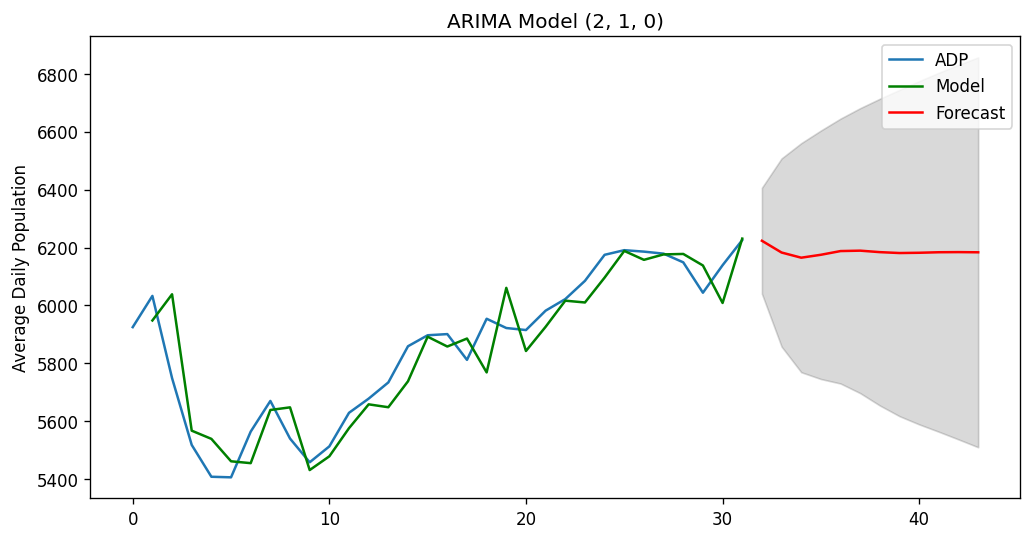

In [35]:
forecast_exo = model1_admission_cnt_IV.values
#forecast
model = SARIMAX(ts, order=order)
model_fit = model.fit()
IS_pred = model_fit.predict()
pred = model_fit.get_forecast(steps=12, exog = forecast_exo)
fc_series = pd.Series(pred.summary_frame()['mean'].values)
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)


plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.iloc[1:].index,IS_pred.iloc[1:],color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order}')
plt.legend(loc = 'upper right')
plt.show()

In [36]:
fc

ADP,mean,mean_se,mean_ci_lower,mean_ci_upper
32,6223.540477,93.445270,6040.391114,6406.689841
33,6182.907304,165.926976,5857.696407,6508.118201
34,6165.035683,201.944980,5769.230795,6560.840572
35,6175.125140,219.107919,5745.681511,6604.568770
36,6187.950741,233.576147,5730.149905,6645.751578
37,6189.365161,251.292652,5696.840613,6681.889708
38,6184.205382,270.468982,5654.095918,6714.314847
39,6181.152306,287.718541,5617.234329,6745.070283
40,6182.067307,302.654408,5588.875568,6775.259045
41,6183.880485,316.560064,5563.434160,6804.326809


ARIMA(2,1,0) reports all the terms are statistically significant at $\alpha = 0.05$ and the out of sample prediction is minimal. I am going to attempt to add a seasonal component to the model by analyzing the seasonal component of the signal.

In [37]:
#see if the seasonal signal is stationary or not
result = adfuller(results.seasonal)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -110832997312710.046875
p-value: 0.000000
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646


The seasonal signal is stationary so D = 0. Let's check out the ACF and PACF charts

Text(0.5, 1.0, 'Partial Autocorrelation')

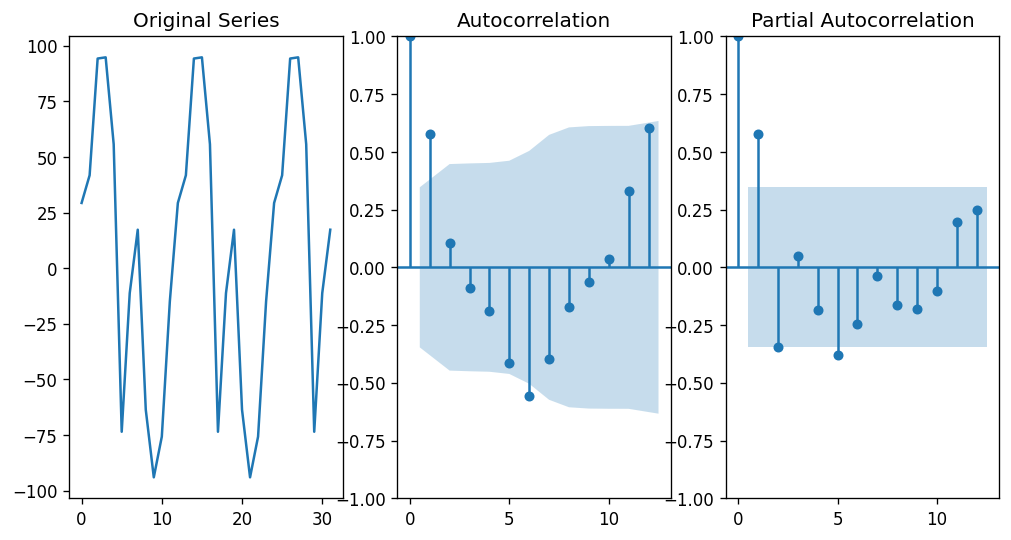

In [38]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(1, 3)
axes[0].plot(results.seasonal); axes[0].set_title('Original Series')

plot_acf(results.seasonal, lags = 12, ax = axes[1])
axes[1].set_title('Autocorrelation')

plot_pacf(results.seasonal, lags = 12, ax=axes[2])
axes[2].set_title('Partial Autocorrelation')

Based on the plot above, the seasonal component is autoregressive as well. I am going to first use $P=2$ and see how our model performance changes.

The in sample MAE is:  313.10195238314725
The out of sample MAE is:  44.484142385066924
                                     SARIMAX Results                                      
Dep. Variable:                                ADP   No. Observations:                   25
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -144.078
Date:                            Wed, 06 Mar 2024   AIC                            296.155
Time:                                    09:09:57   BIC                            300.867
Sample:                                         0   HQIC                           297.405
                                             - 25                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5104     

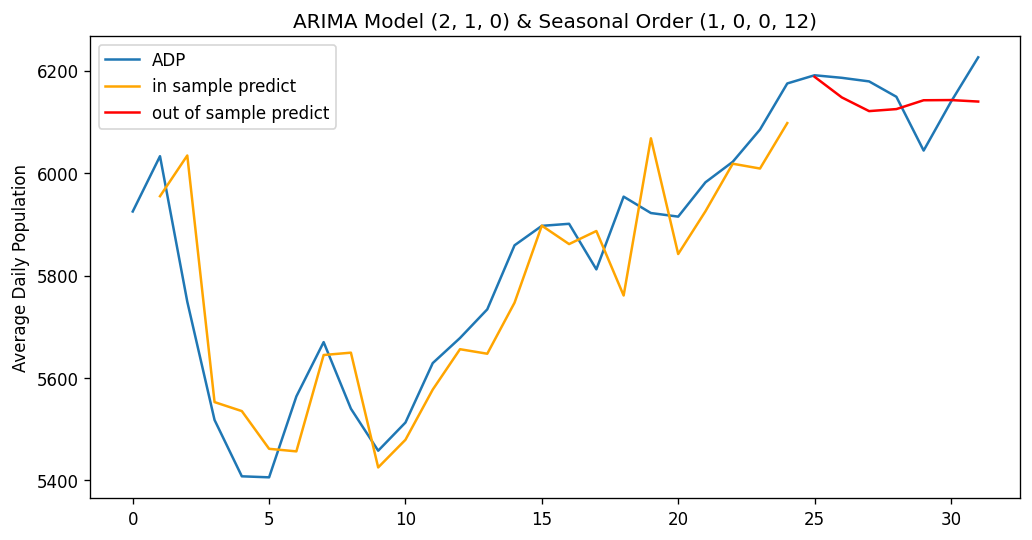

In [39]:
p=2
d=1
q=0
order = (p,d,q)
P = 1
D = 0
Q = 0
s = 12
seasonal_order = (P,D,Q,s)

# fit model
train_size = int(len(ts)*0.8)
#train test split
series_train =  ts.iloc[:train_size]
series_test = ts.iloc[train_size:]

model = SARIMAX(series_train, order=order,seasonal_order=seasonal_order)
model_fit = model.fit()
IS_pred = model_fit.predict()
pred = model_fit.get_forecast(steps=len(series_test))
IS_mae = mean_absolute_error(series_train, IS_pred)
OS_mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The in sample MAE is: ', IS_mae)
print('The out of sample MAE is: ', OS_mae)
print(model_fit.summary())

#plot
# Perform in-sample predictions
train_predictions = model_fit.predict()
fc_series = pd.Series(pred.summary_frame()['mean'].values)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # train
ax.plot(series_train.iloc[1:].index,train_predictions.iloc[1:],color='orange',label='in sample predict') # in-sample
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order} & Seasonal Order {seasonal_order}')
plt.legend()
plt.show()

The seasonal components are not statistically significant... Lets go back to the non-seasonal model

Lets see if this output is what pmdarima would have concluded.

In [40]:
# Fit a simple auto_arima model
auto_arima = pm.auto_arima(ts, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=395.219, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=379.429, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=380.430, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=380.819, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=377.702, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=381.389, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=381.401, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=383.329, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=378.660, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=381.296, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=383.471, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.850 seconds


In [41]:
auto_arima.get_params()

{'maxiter': 5,
 'method': 'lbfgs',
 'order': (0, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

Seems like the optimal model based on pdmarima autoarima package is the same as our, lets plot residual statistics.

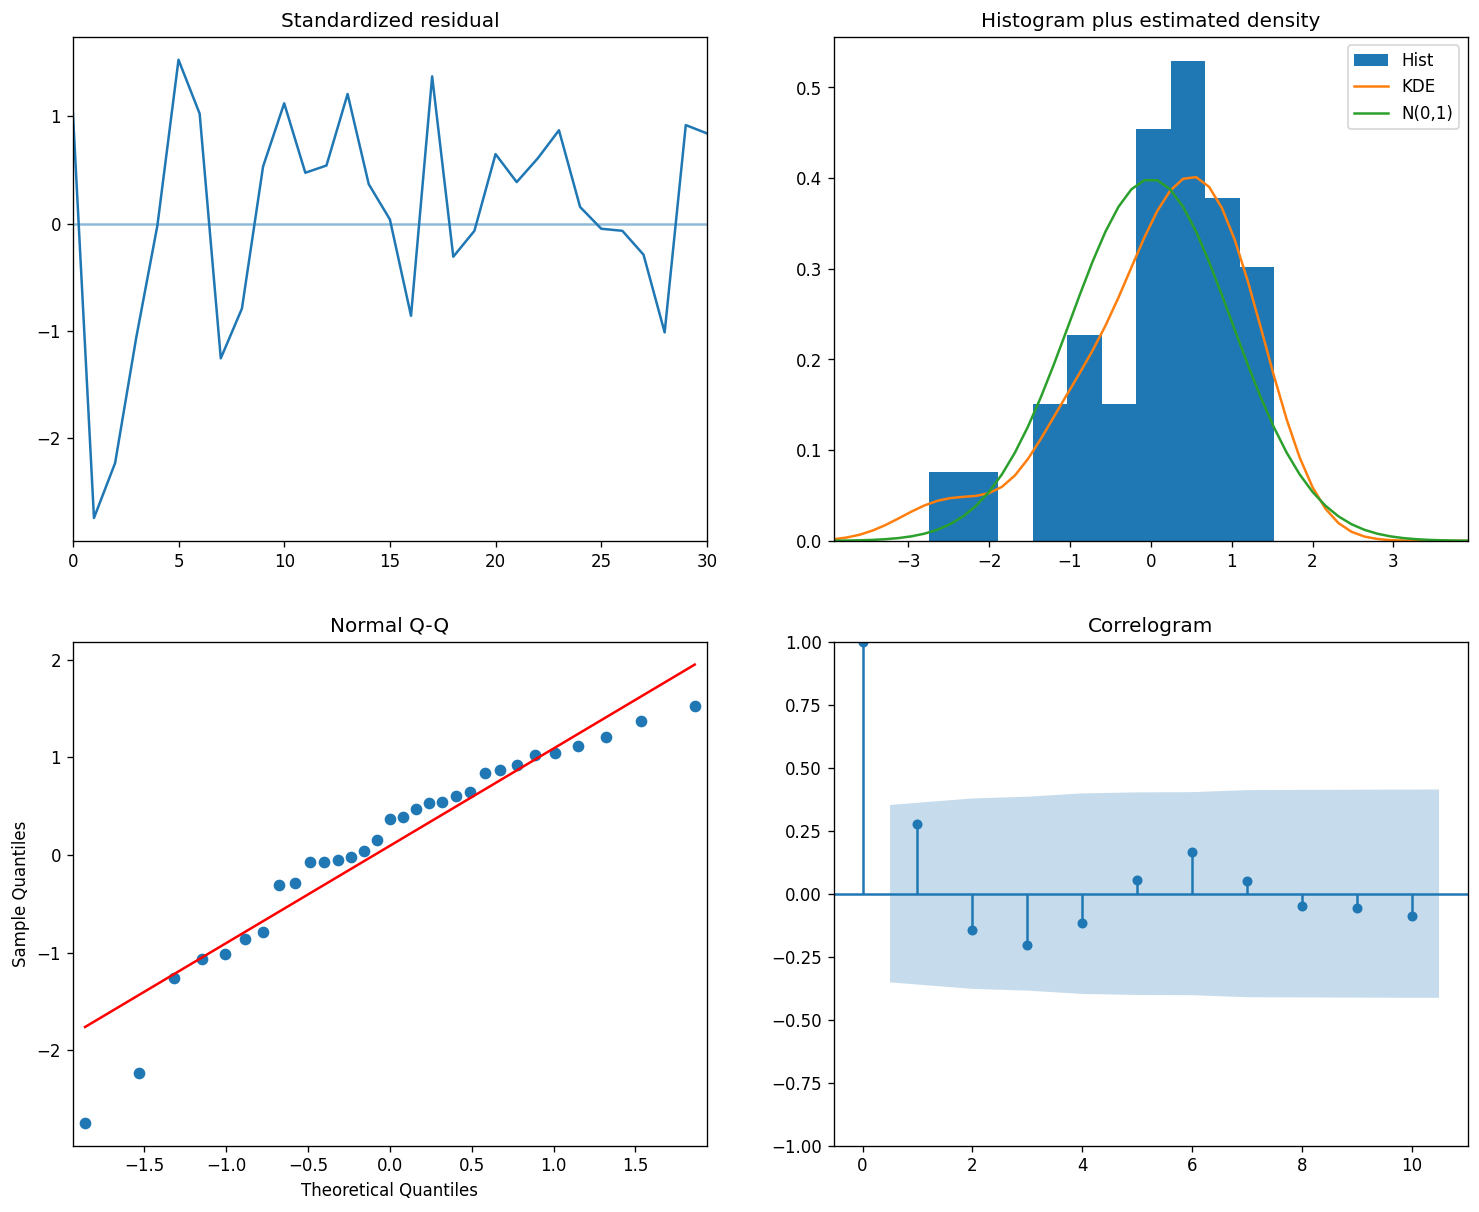

In [42]:
auto_arima.plot_diagnostics(figsize=(15,12))
plt.show()

I like this model the best, lets bring in exogenous variables now.

In [43]:
exo_vars = _30day_pop_tot[['admission_count', 'discharge_count','los_days']]

The in sample MAE is:  240.2362805078042
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   32
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -180.595
Date:                Wed, 06 Mar 2024   AIC                            373.190
Time:                        09:10:00   BIC                            381.794
Sample:                             0   HQIC                           375.994
                                 - 32                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
admission_count     0.1924      0.092      2.091      0.036       0.012       0.373
discharge_count     0.0028      0.118      0.024      0.981      -0.228    

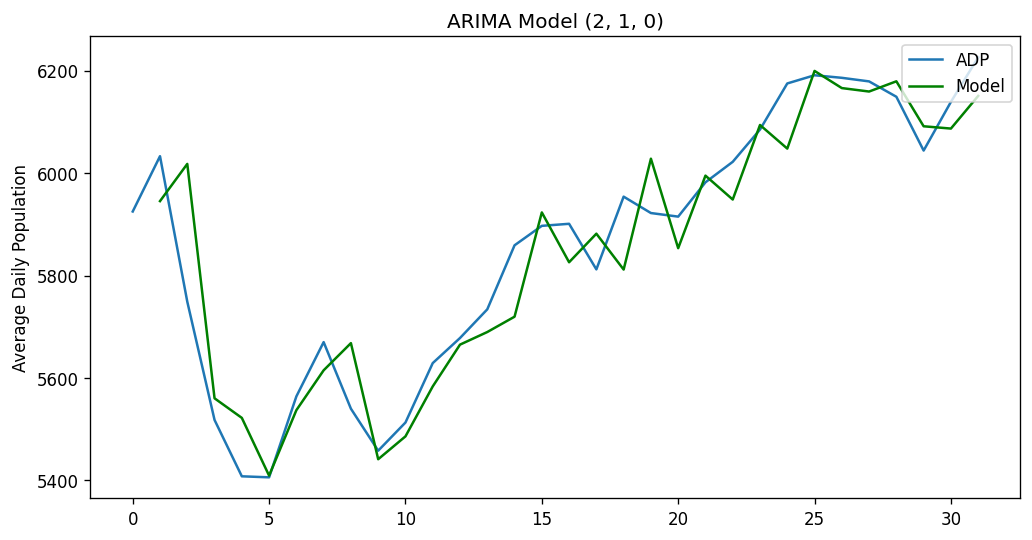

In [44]:
#this is exactly the same as the previous model without exogenous variables... Lets use statsmodel arima with same coef
p=2
d=1
q=0
order = (p,d,q)

model = SARIMAX(ts, order=order, exog = exo_vars)
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(ts, IS_pred)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.iloc[1:].index,IS_pred.iloc[1:],color='green',label='Model') # MODEL

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order}')
plt.legend(loc = 'upper right')
plt.show()

The in sample MAE is:  295.1375588211641
The out of sample MAE is:  36.62943603250135
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   25
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -142.286
Date:                Wed, 06 Mar 2024   AIC                            292.572
Time:                        09:10:00   BIC                            297.285
Sample:                             0   HQIC                           293.823
                                 - 25                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
admission_count     0.1696      0.135      1.259      0.208      -0.094       0.434
ar.L1               0.5361    

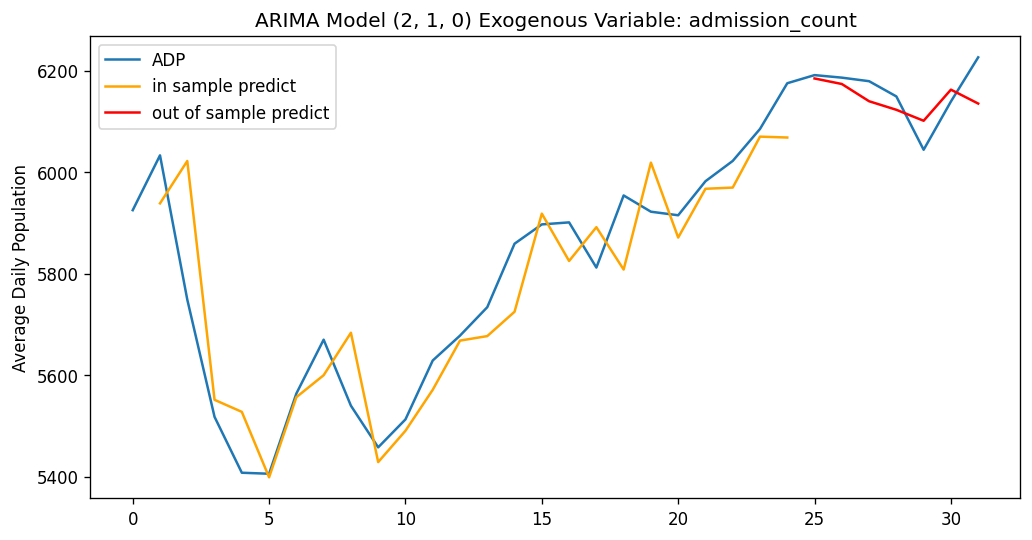

In [45]:
#lets just look at admission_count as the exog bc it seems to be the only statistically significant IV
#this is exactly the same as the previous model without exogenous variables... Lets use statsmodel arima with same coef
p=2
d=1
q=0
order = (p,d,q)

# fit model
train_size = int(len(ts)*0.8)
#train test split
series_train =  ts.iloc[:train_size]
series_test = ts.iloc[train_size:]
exo_train = _30day_pop_tot['admission_count'].iloc[:train_size]
exo_test = _30day_pop_tot['admission_count'].iloc[train_size:]
model = SARIMAX(series_train, order=order,exog = exo_train)
model_fit = model.fit()
IS_pred = model_fit.predict()
pred = model_fit.get_forecast(steps=len(series_test),exog = exo_test)
IS_mae = mean_absolute_error(series_train, IS_pred)
OS_mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The in sample MAE is: ', IS_mae)
print('The out of sample MAE is: ', OS_mae)
print(model_fit.summary())

#plot
# Perform in-sample predictions
train_predictions = model_fit.predict()
fc_series = pd.Series(pred.summary_frame()['mean'].values)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # train
ax.plot(series_train.iloc[1:].index,train_predictions.iloc[1:],color='orange',label='in sample predict') # in-sample
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order} Exogenous Variable: admission_count')
plt.legend()
plt.show()

The in sample MAE is:  238.544164363788
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   32
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -181.012
Date:                Wed, 06 Mar 2024   AIC                            370.025
Time:                        09:10:01   BIC                            375.761
Sample:                             0   HQIC                           371.895
                                 - 32                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
admission_count     0.1760      0.098      1.798      0.072      -0.016       0.368
ar.L1               0.5337      0.272      1.965      0.049       0.001     

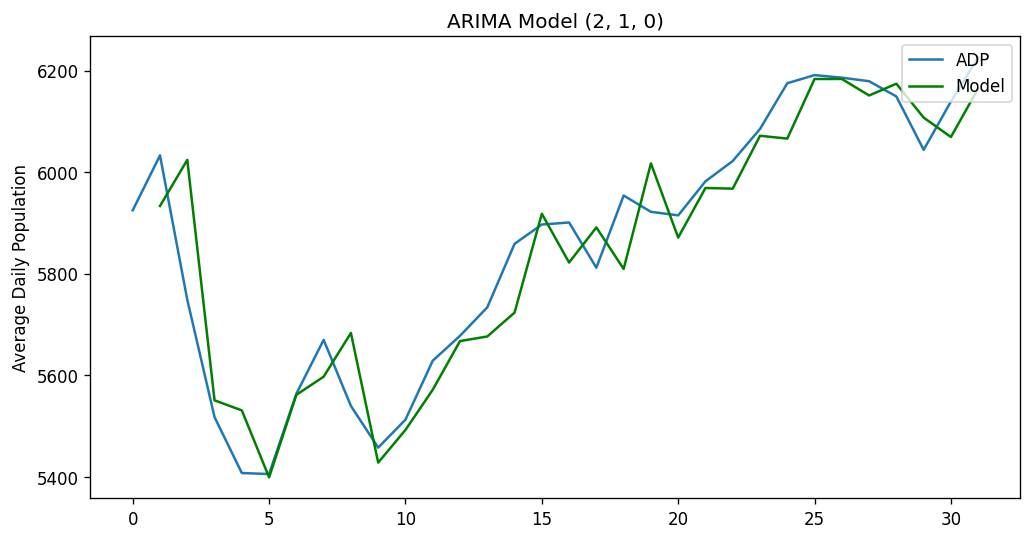

In [46]:
#lets just look at admission_count as the exog bc it seems to be the only statistically significant IV
#this is exactly the same as the previous model without exogenous variables... Lets use statsmodel arima with same coef
p=2
d=1
q=0
order = (p,d,q)

model = SARIMAX(ts, order=order, exog = _30day_pop_tot['admission_count'])
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(ts, IS_pred)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.iloc[1:].index,IS_pred.iloc[1:],color='green',label='Model') # MODEL

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order}')
plt.legend(loc = 'upper right')
plt.show()

Using the admission forecast values calculated during our linear regression section, we can forecast ADP using the arima model above.

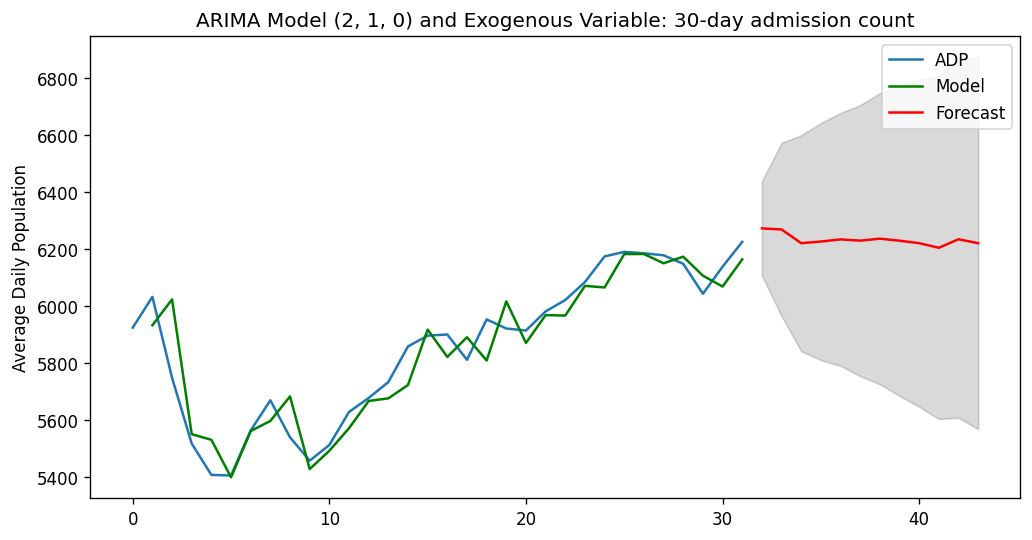

In [47]:
forecast_exo = model1_admission_cnt_IV.values
#forecast
pred = model_fit.get_forecast(steps=12, exog = forecast_exo)
fc_series = pd.Series(pred.summary_frame()['mean'].values)
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)


plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.iloc[1:].index,IS_pred.iloc[1:],color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order} and Exogenous Variable: 30-day admission count')
plt.legend(loc = 'upper right')
plt.show()

In [48]:
fc

ADP,mean,mean_se,mean_ci_lower,mean_ci_upper
32,6273.393722,84.692208,6107.400044,6439.387400
33,6269.683875,155.065214,5965.761641,6573.606110
34,6221.494238,193.421357,5842.395344,6600.593132
35,6227.326877,212.290389,5811.245360,6643.408393
36,6234.772163,226.500237,5790.839856,6678.704470
37,6230.419932,242.691686,5754.752967,6706.086896
38,6237.313401,260.770433,5726.212745,6748.414057
39,6230.176306,277.909947,5685.482818,6774.869794
40,6221.485624,292.966991,5647.280874,6795.690374
41,6205.452528,306.656992,5604.415867,6806.489188


Finally, after fitting 4 different models we have the following results:

|Model Type | IVs | In Sample MAE | Out of Sample MAE | Significance $\alpha$ = 0.05 |
|-----------|-----|---------------|-------------------|------------|
|MLR | ['Date_Rank','adp_lag4','admission_count'] | 72.64 | 55.37 | No|
|MLR | ['sqrt_Date_Rank','adp_lag4','admission_count'] | 96.78 | 200.2 | Yes|
|MLR | ['sqrt_Date_Rank','adp_lag4','admit_lag3'] | 86.49 | 85.86 | Yes|
|ARIMA | (2,1,0) | 311.81 | 37.34 | Yes|
|ARIMAX | (2,1,0) & admission_count | 294.24 | 34.19 | Yes|

The ARIMA models have a high in sample error due to the first two fitted data points being inaccurate since we need 2 autoregressive and 2 differencing terms to measure our target variable. IS MAE would be much small if we excluded those from the calculation.

As for which model to pick, I am leaning towards using the ARIMAX model as it is dependent on the predicted future admission counts. We intuitively know the jail population is not going to increase boundlessly into the future. DOC admissions tend to be rather stable over time with seasonal fluctuations during the end of year holiday season. Based on the up-ward trend of the jail population, somewhat stable admission rates and the knowledge that the Adams Administration is under pressure from advocate groups and the federal government, I don't think we should assume the population will continue to below as seen in the linear regression outputs. 

That being said, the final projection from the linear regression is only ~200-300 people higher than the current ADP. Therefore they are not unreasonable. I think they may just be on the higher end of our prediction spectrum. 

Since the ARIMA models autogenerate the 95% CI automatically, I will attempt to generate this for the MLRs using a frequentist approach.

In [49]:
def fit_OLS_feature_selection(data,time_regressor_str):
    """
    This function will fit the OLS model on the features selected to best optimize OS MAE.
    These features are:

    1. time_regressor_str: Variable name representing the relationship between time and ADP. The options are as follows:
    
            Date_Rank: Discrete numeric ranging from 0 to n where n is the last date period ranked in ascending order.
            sqrt_Date_Rank: The square root of the integer rangings from 0 to n.

    2. monthly admission count

    3. adp_lag4: the average daily population 4 months prior to the current time period
    -----
    Parameters - 
    data: Pandas Dataframe
        Must have columns 'Start Date', 'End Date', and 'Total Population'
    
    Returns - 
    fc_12: Numpy array
        12 forecasted 30-day periods
    model: Numpy array
        the model fitted to the actual data
    IS_mae: float
        in sample MAE
    """
    #step 1: retrieve the admission data
    _30_day_admission_df = get_agg_admit_dis_data(data.iloc[0]['Start Date'].date(),admit_url,'ADMITTED_DT')
    #specify data types for merge
    _30_day_admission_df['Start Date'] = _30_day_admission_df['Start Date'].astype('datetime64[ns, America/New_York]')
    _30_day_admission_df['End Date'] = _30_day_admission_df['End Date'].astype('datetime64[ns, America/New_York]')

    #step 2: join ADP interval data and admission data on Year & Month & obtain regressors
    data = data.merge(_30_day_admission_df, how = 'left', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])
    #add a unique id for month-year ranks from earliest to latest date
    if time_regressor_str == 'Date_Rank':
        data[time_regressor_str] = data.sort_values(by = ['Year','Month']).index
    elif time_regressor_str == 'sqrt_Date_Rank':
        data[time_regressor_str] = np.sqrt(data.sort_values(by = ['Year','Month']).index)
    #create adp_lag4 variable
    data['adp_lag4'] = data['ADP'].shift(4)
    data = data.fillna(0)
    #select only relevant data
    final_df = data[['ADP',time_regressor_str,'Adjusted Admission Count', 'adp_lag4']]
    #step 3: Fit linear regression
    # Scale the entire dataset
    sc = MinMaxScaler()
    data_sc = sc.fit_transform(final_df)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=final_df.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    # Fit the linear regression model on the entire dataset
    ols_model = sm.OLS(y, X).fit()
    # Make in sample predictions
    IS_pred = ols_model.predict(X)

    #inverse scale the model inputs to get IS predicts
    IS_inputs = pd.concat([IS_pred,X.drop(columns=['const'])],axis = 1)
    IS_inputs = IS_inputs.rename(columns={0:'ADP'})
    IS_inputs = sc.inverse_transform(IS_inputs)

    #accuracy in terms of non-scaled values
    IS_mae = mean_absolute_error(final_df['ADP'], IS_inputs[:,0])

    #Step 4: Predict Admission Counts for next 12 time periods, propogate regressors and predict
    #predict admission using an arima model optimized in another project
    #fit model to data
    p=0
    d=1
    q=1
    order = (p,d,q)
    seasonal_order = (1,0,0,12)

    arima_model = SARIMAX(final_df['Adjusted Admission Count'], order=order,seasonal_order=seasonal_order)
    model_fit = arima_model.fit()
    # Perform in-sample predictions
    train_predictions = model_fit.predict()
    #forecast
    pred = model_fit.get_forecast(steps=12)
    fc_series = pd.Series(pred.summary_frame()['mean'].values)
    #create a dataframe to store prediction regressors
    forecast_regressors = pd.DataFrame(columns=final_df.columns)
    if time_regressor_str == 'Date_Rank':
        forecast_regressors[time_regressor_str] = np.arange(len(final_df),len(final_df)+12)
    elif time_regressor_str == 'sqrt_Date_Rank':
        forecast_regressors[time_regressor_str] = np.sqrt(np.arange(len(final_df),len(final_df)+12))
    
    #store admission predictions
    forecast_regressors['Adjusted Admission Count'] = fc_series.round()
    #adp_lag4 for the first four predictions (this is all historical adp data)
    forecast_regressors.iloc[0:4,3] = final_df['ADP'][-4:]
    #predict
    for i in range(1,4):
        #first scale first four regressors
        regressors = forecast_regressors.iloc[4*(i-1):4*i]
        #scale
        data_sc = sc.transform(regressors)
        # Convert the array to a DataFrame
        data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors.columns)
        # Add constant to the dataset
        data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

        # Split the dataset into features (X) and target (y)
        X = data_sc.drop(columns=['ADP'])
        y = data_sc['ADP']

        OS_pred = ols_model.predict(X)
        #do the same with OS data
        OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
        OS_inputs = OS_inputs.rename(columns={0:'ADP'})
        OS_inputs = sc.inverse_transform(OS_inputs)
        #set the first four ADP in the regressor df to the predicted output
        forecast_regressors.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
        #set the next four ADP lag terms in the regressor df to the predicted output
        #exclude the last interation
        if i < 3:
            forecast_regressors.iloc[4*i:4*(i+1),3] = OS_inputs[:,0]

    fc_12 = forecast_regressors['ADP']
    return ols_model,IS_inputs[:,0], fc_12, IS_mae


### Create condifendce intervals using the residuals of the model

The one issue with this is that the error of the predicted admission counts is not included. This assumes those predicted values have no error and will be exact.

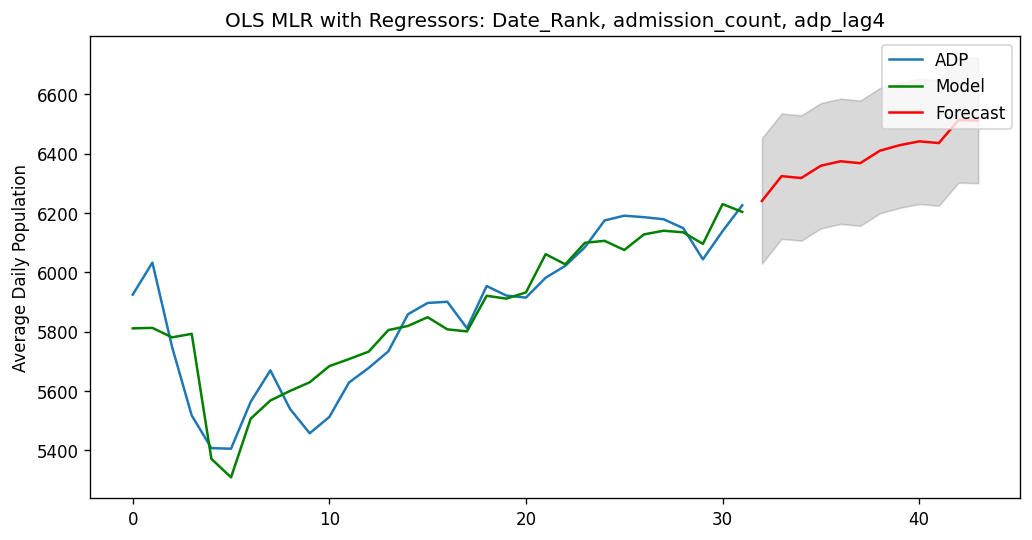

In [50]:
from scipy import stats

model_fit,IS_pred, fc_12, mae = fit_OLS_feature_selection(_30day_pop_tot[['Start Date', 'End Date', 'ADP']],'Date_Rank')
sc = MinMaxScaler()
adp_sc = sc.fit_transform(np.asarray(_30day_pop_tot['ADP']).reshape(-1, 1))
# Step 1: Calculate standard error of the forecast
residuals = model_fit.resid
residuals = sc.inverse_transform(np.asarray(residuals).reshape(-1, 1))
forecast_error_std = np.std(residuals)

# Step 2: Determine critical value for 95% confidence level
# Since we want a two-tailed test, we divide alpha by 2
alpha = 0.05
n = len(fc_12)
df = n - 1  # degrees of freedom
t_critical = stats.t.ppf(1 - alpha / 2, df)

# Step 3: Calculate margin of error
margin_of_error = t_critical * forecast_error_std

# Step 4: Calculate upper and lower bounds of the confidence interval
lower_bound = pd.to_numeric(fc_12 - margin_of_error)
upper_bound = pd.to_numeric(fc_12 + margin_of_error)

#plot
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.index,IS_pred,color='green',label='Model') # MODEL
ax.plot(np.arange(len(ts),len(ts)+12),fc_12,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(np.arange(len(ts),len(ts)+12), lower_bound.values, upper_bound.values, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'OLS MLR with Regressors: Date_Rank, admission_count, adp_lag4')
plt.legend(loc = 'upper right')
plt.show()

In [51]:
print(fc_12[11], lower_bound[11], upper_bound[11])

6511.499629576691 6300.447338558649 6722.551920594734


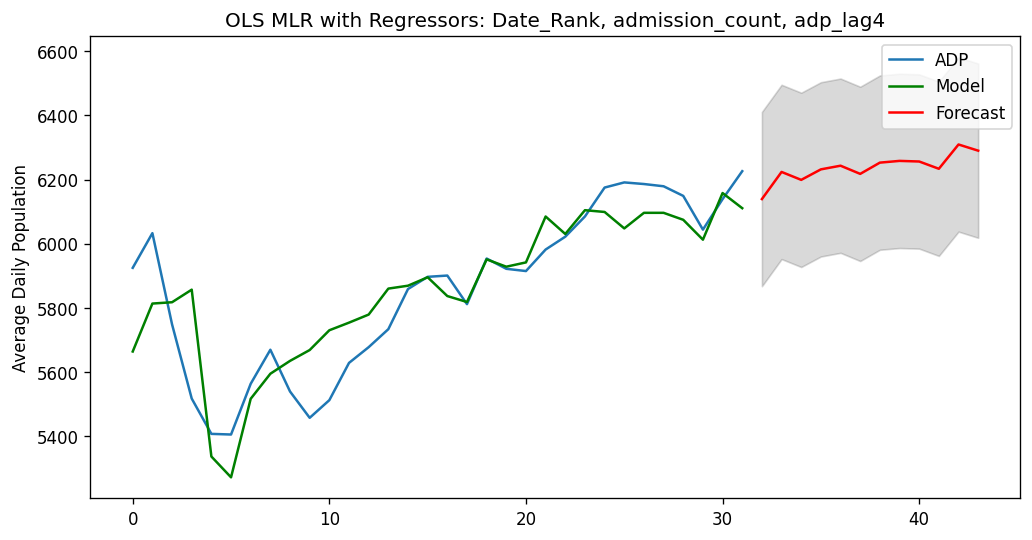

6289.861581086067 6018.4754353549 6561.247726817235


In [52]:
model_fit,IS_pred, fc_12, mae = fit_OLS_feature_selection(_30day_pop_tot[['Start Date', 'End Date', 'ADP']],'sqrt_Date_Rank')
sc = MinMaxScaler()
adp_sc = sc.fit_transform(np.asarray(_30day_pop_tot['ADP']).reshape(-1, 1))
# Step 1: Calculate standard error of the forecast
residuals = model_fit.resid
residuals = sc.inverse_transform(np.asarray(residuals).reshape(-1, 1))
forecast_error_std = np.std(residuals)

# Step 2: Determine critical value for 95% confidence level
# Since we want a two-tailed test, we divide alpha by 2
alpha = 0.05
n = len(fc_12)
df = n - 1  # degrees of freedom
t_critical = stats.t.ppf(1 - alpha / 2, df)

# Step 3: Calculate margin of error
margin_of_error = t_critical * forecast_error_std

# Step 4: Calculate upper and lower bounds of the confidence interval
lower_bound = pd.to_numeric(fc_12 - margin_of_error)
upper_bound = pd.to_numeric(fc_12 + margin_of_error)

#plot
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.index,IS_pred,color='green',label='Model') # MODEL
ax.plot(np.arange(len(ts),len(ts)+12),fc_12,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(np.arange(len(ts),len(ts)+12), lower_bound.values, upper_bound.values, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'OLS MLR with Regressors: Date_Rank, admission_count, adp_lag4')
plt.legend(loc = 'upper right')
plt.show()

print(fc_12[11], lower_bound[11], upper_bound[11])

### Create confidence intervals via frequentist approach

We are going to use the simulate method in SARIMAX to produce different future admission counts that will then be fed into our MLR.

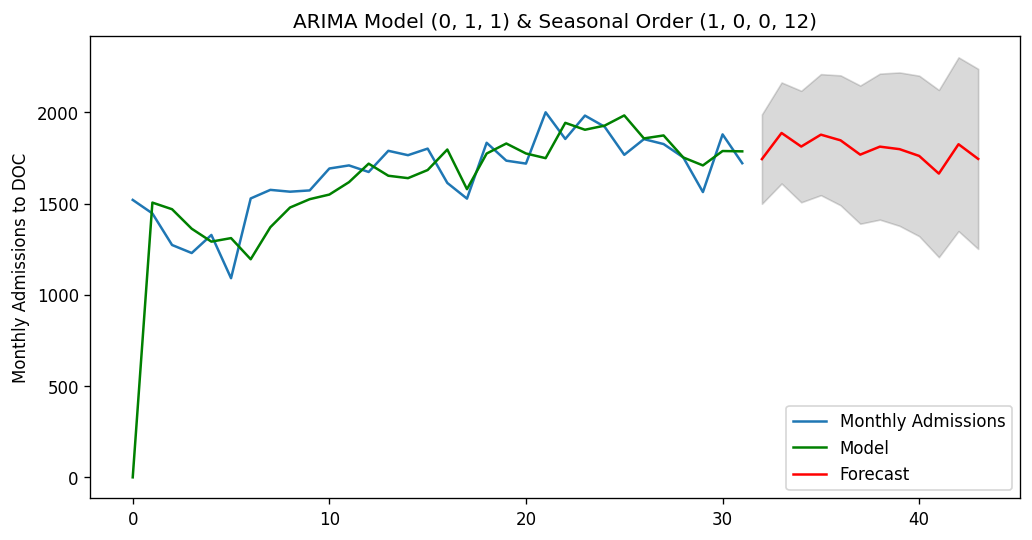

In [53]:
#STEP 2: Forecast. Let's predict 30-day admission counts for 12 future time periods
#fit model to data
p=0
d=1
q=1
order = (p,d,q)
seasonal_order = (1,0,0,12)
#admission count
series = _30day_pop_tot['admission_count']

admit_arima_model = SARIMAX(series, order=order,seasonal_order=seasonal_order)
admit_arima_model_fit = admit_arima_model.fit()
# Perform in-sample predictions
train_predictions = admit_arima_model_fit.predict()
#forecast
pred = admit_arima_model_fit.get_forecast(steps=12)

fc_series = pd.Series(pred.summary_frame()['mean'].values)
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Admissions') # ACTUAL DATA
ax.plot(series.index,train_predictions,color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Monthly Admissions to DOC')
plt.title(f'ARIMA Model {order} & Seasonal Order {seasonal_order}')
plt.legend(loc = 'lower right')
plt.show()

In [57]:
#simulations
simulation_results = admit_arima_model_fit.simulate(nsimulations=12,repetitions= 10, anchor = 'end')
simulation_results.shape

(12, 10)

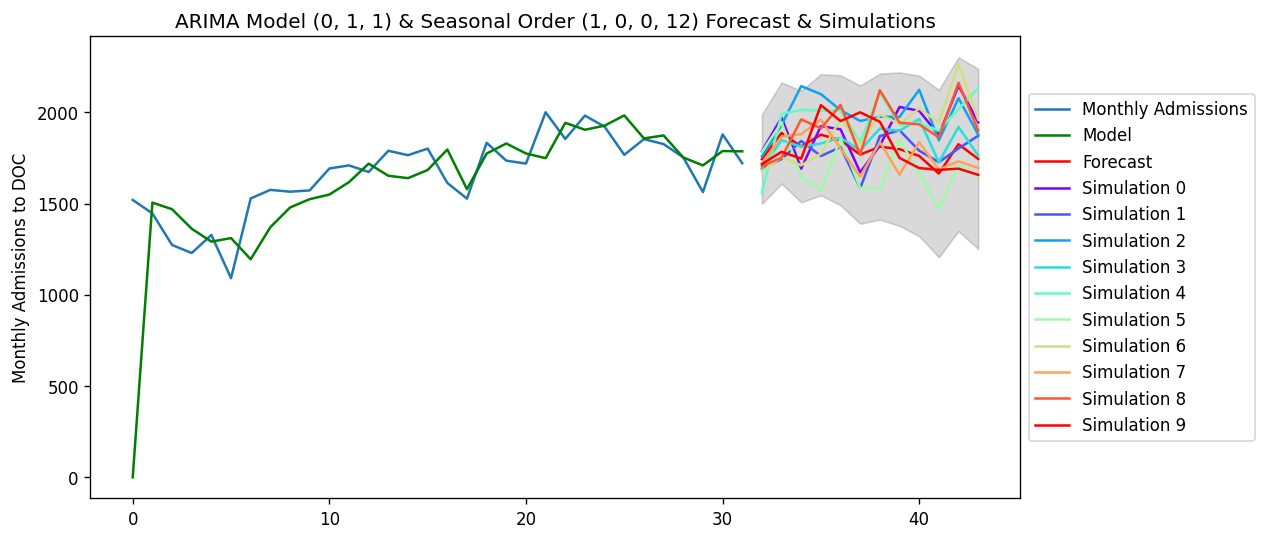

In [67]:
#plot
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Admissions') # ACTUAL DATA
ax.plot(series.index,train_predictions,color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

# Generate rainbow colors
num_simulations = len(simulation_results.columns)
colors = plt.cm.rainbow(np.linspace(0, 1, num_simulations))

for i, color in zip(range(num_simulations), colors):
    ax.plot(fc.index, simulation_results['admission_count', i].values, color=color, label=f'Simulation {i}') # 12 MONTH Simulation

plt.xlabel('')
plt.ylabel('Monthly Admissions to DOC')
plt.title(f'ARIMA Model {order} & Seasonal Order {seasonal_order} Forecast & Simulations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [95]:
#lets do a bunch more simulations and then use those as our admission_count input regressors for the ADP predictions
#simulations
simulation_results = admit_arima_model_fit.simulate(nsimulations=12,repetitions= 1000, anchor = 'end')
print(simulation_results.shape)

#iterate through the columns in the simulation results and predict the ADP for our different models
num_simulations = len(simulation_results.columns)

#first let's compute CI for model_1 using Date_Rank, admission_count & adp_lag4 variables
time_regressor_str = 'Date_Rank'
#define df to hold 1000 forecasts
fc_1000 = pd.DataFrame(index = range(num_simulations), columns = range(12))
#define minmaxscalar based on the input data
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP','Date_Rank','admission_count','adp_lag4']]
data_sc = sc.fit_transform(data)
# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)
# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')
# Split the dataset into features (X) and target (y)
X_model1 = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

for n in range(num_simulations):
    #set random seed for each iteration
    np.random.seed(123*n+1)
    # Make in sample predictions
    # Fit the linear regression model on the entire dataset
    model_1 = sm.OLS(y, X_model1).fit()
    #create a dataframe to store prediction regressors
    forecast_regressors = pd.DataFrame(columns=data.columns)
    if time_regressor_str == 'Date_Rank':
        forecast_regressors[time_regressor_str] = np.arange(len(data),len(data)+12)
    elif time_regressor_str == 'sqrt_Date_Rank':
        forecast_regressors[time_regressor_str] = np.sqrt(np.arange(len(data),len(data)+12))
    
    #set the variable used for the future regressors in the fit_ols_feature_selection function
    #to be the simulated output
    #store admission predictions
    forecast_regressors['admission_count'] = simulation_results['admission_count',n].values
    #adp_lag4 for the first four predictions (this is all historical adp data)
    forecast_regressors.iloc[0:4,3] = data['ADP'][-4:]
    #predict
    for i in range(1,4):
        #first scale first four regressors
        regressors = forecast_regressors.iloc[4*(i-1):4*i]
        #scale
        data_sc = sc.transform(regressors)
        # Convert the array to a DataFrame
        data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors.columns)
        # Add constant to the dataset
        data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

        # Split the dataset into features (X) and target (y)
        X2 = data_sc.drop(columns=['ADP'])
        y2 = data_sc['ADP']

        OS_pred = model_1.predict(X2)
        #do the same with OS data
        OS_inputs = pd.concat([OS_pred,X2.drop(columns=['const'])],axis = 1)
        OS_inputs = OS_inputs.rename(columns={0:'ADP'})
        OS_inputs = sc.inverse_transform(OS_inputs)
        #set the first four ADP in the regressor df to the predicted output
        forecast_regressors.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
        #set the next four ADP lag terms in the regressor df to the predicted output
        #exclude the last interation
        if i < 3:
            forecast_regressors.iloc[4*i:4*(i+1),3] = OS_inputs[:,0]

    fc_1000.iloc[n] = forecast_regressors['ADP'].values

(12, 1000)


In [96]:
forecast_regressors

,ADP,Date_Rank,admission_count,adp_lag4
0,6228.046927,32,1706.703398,6149.0
1,6278.509835,33,1751.881986,6044.0
2,6298.132818,34,1753.907229,6139.0
3,6338.609427,35,1815.667325,6226.0
4,6347.712464,36,1764.267379,6228.046927
5,6371.979698,37,1769.328669,6278.509835
6,6423.338372,38,1847.082771,6298.132818
7,6448.262323,39,1851.687593,6338.609427
8,6478.869726,40,1865.562071,6347.712464
9,6510.717993,41,1886.746841,6371.979698


In [97]:
fc_1000.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,6266.391694,6242.633804,6294.88897,6304.550613,6417.213644,6329.857594,6443.322848,6426.259103,6442.399145,6412.150813,6473.247429,6419.165749
1,6279.551333,6313.307553,6290.024286,6291.878615,6325.63394,6271.803728,6365.875981,6371.928206,6371.601413,6313.157132,6434.757719,6411.544139
2,6314.633094,6349.176621,6382.066744,6471.45185,6418.07424,6465.600952,6514.997459,6491.806934,6635.108574,6535.689811,6619.693459,6582.550537
3,6223.914063,6242.314264,6294.568341,6314.276732,6361.389456,6310.203069,6340.566013,6309.401256,6395.993839,6367.414769,6439.644993,6450.06748
4,6204.988361,6322.176182,6322.483619,6348.398961,6407.293416,6420.493097,6392.515976,6430.154504,6399.820881,6376.800795,6492.023013,6470.984492


In [115]:
import scipy.stats

#now construct 95% CI for each column
# Calculate mean and standard deviation for each column (sample)
means = fc_1000.mean()
std_devs = fc_1000.std()

# Calculate lower and upper bounds of the confidence interval
lower_bound = pd.to_numeric(means - 2*std_devs).values
upper_bound = pd.to_numeric(means + 2*std_devs).values

# Print or use the lower_bound_array and upper_bound_array as needed
print("Lower Bound Array:", lower_bound)
print("Upper Bound Array:", upper_bound)


Lower Bound Array: [6155.74733729 6230.28158695 6212.75791406 6244.58230767 6257.2452873
 6244.44374208 6281.89267937 6296.29753936 6300.5447827  6289.49436645
 6356.14384475 6347.42816116]
Upper Bound Array: [6323.85986086 6416.83207988 6423.36023134 6476.23471927 6494.69199486
 6497.01444321 6546.11177692 6568.67277503 6588.38519473 6587.70912369
 6677.65273561 6680.03377446]


In [109]:
#second let's compute CI for model_2 using sqrt_Date_Rank, admission_count & adp_lag4 variables
time_regressor_str = 'sqrt_Date_Rank'
#define df to hold 1000 forecasts
fc_1000_model2 = pd.DataFrame(index = range(num_simulations), columns = range(12))
#define minmaxscalar based on the input data
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP','sqrt_Date_Rank','admission_count','adp_lag4']]
data_sc = sc.fit_transform(data)
# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)
# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')
# Split the dataset into features (X) and target (y)
X_model1 = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

for n in range(num_simulations):
    #set random seed for each iteration
    np.random.seed(123*n+1)
    # Make in sample predictions
    # Fit the linear regression model on the entire dataset
    model_1 = sm.OLS(y, X_model1).fit()
    #create a dataframe to store prediction regressors
    forecast_regressors = pd.DataFrame(columns=data.columns)
    if time_regressor_str == 'Date_Rank':
        forecast_regressors[time_regressor_str] = np.arange(len(data),len(data)+12)
    elif time_regressor_str == 'sqrt_Date_Rank':
        forecast_regressors[time_regressor_str] = np.sqrt(np.arange(len(data),len(data)+12))
    
    #set the variable used for the future regressors in the fit_ols_feature_selection function
    #to be the simulated output
    #store admission predictions
    forecast_regressors['admission_count'] = simulation_results['admission_count',n].values
    #adp_lag4 for the first four predictions (this is all historical adp data)
    forecast_regressors.iloc[0:4,3] = data['ADP'][-4:]
    #predict
    for i in range(1,4):
        #first scale first four regressors
        regressors = forecast_regressors.iloc[4*(i-1):4*i]
        #scale
        data_sc = sc.transform(regressors)
        # Convert the array to a DataFrame
        data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors.columns)
        # Add constant to the dataset
        data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

        # Split the dataset into features (X) and target (y)
        X2 = data_sc.drop(columns=['ADP'])
        y2 = data_sc['ADP']

        OS_pred = model_1.predict(X2)
        #do the same with OS data
        OS_inputs = pd.concat([OS_pred,X2.drop(columns=['const'])],axis = 1)
        OS_inputs = OS_inputs.rename(columns={0:'ADP'})
        OS_inputs = sc.inverse_transform(OS_inputs)
        #set the first four ADP in the regressor df to the predicted output
        forecast_regressors.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
        #set the next four ADP lag terms in the regressor df to the predicted output
        #exclude the last interation
        if i < 3:
            forecast_regressors.iloc[4*i:4*(i+1),3] = OS_inputs[:,0]

    fc_1000_model2.iloc[n] = forecast_regressors['ADP'].values
#now construct 95% CI for each column
# Calculate mean and standard deviation for each column (sample)
means = fc_1000_model2.mean()
std_devs = fc_1000_model2.std()

# Calculate the sample size (number of simulations)
sample_size = fc_1000_model2.shape[0]

# Calculate the t-value for a 95% confidence interval (two-tailed)
confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=sample_size - 1)
# Calculate standard error
standard_errors = std_devs / np.sqrt(sample_size)

# Calculate margin of error
margin_of_error = t_value * standard_errors

# Calculate lower and upper bounds of the confidence interval
lower_bound_m2 = pd.to_numeric(means - 2*std_devs).values
upper_bound_m2 = pd.to_numeric(means + 2*std_devs).values


# Print or use the lower_bound_array and upper_bound_array as needed
print("Lower Bound Array:", lower_bound_m2)
print("Upper Bound Array:", upper_bound_m2)


Lower Bound Array: [6037.29990659 6110.98840687 6073.01484983 6094.03187754 6103.34649499
 6070.59825201 6100.38480363 6101.15452006 6088.87878085 6059.96385147
 6122.44465441 6095.16652856]
Upper Bound Array: [6238.89093473 6334.68920484 6325.55723495 6371.81634495 6386.71824291
 6371.59262595 6414.71156212 6424.59851563 6430.76465518 6413.76536813
 6503.92954614 6489.70536781]


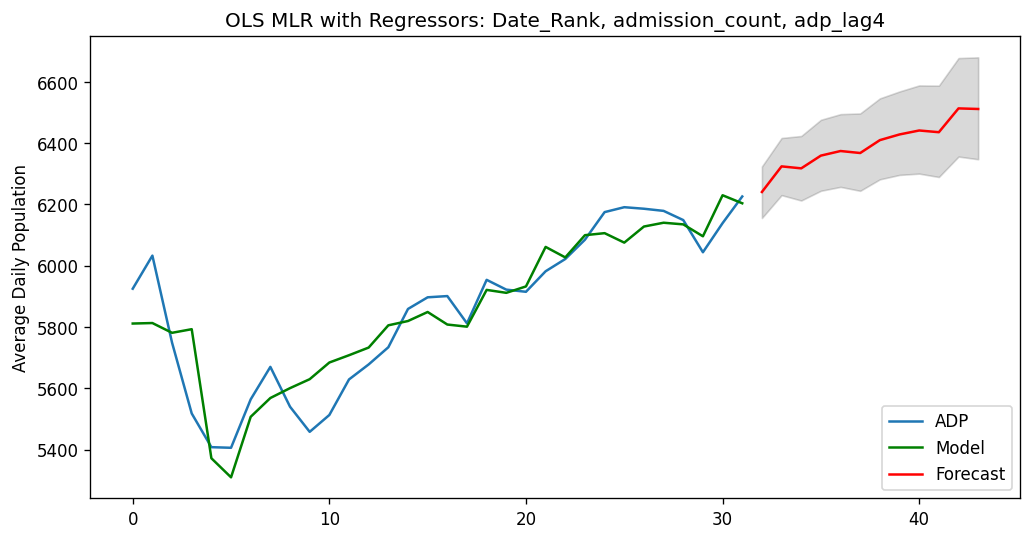

6511.499629576691 6347.428161161967 6680.033774462053


In [116]:
#plot model 1
model_fit,IS_pred, fc_12, mae = fit_OLS_feature_selection(_30day_pop_tot[['Start Date', 'End Date', 'ADP']],'Date_Rank')

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(_30day_pop_tot.index,_30day_pop_tot['ADP'],label='ADP') # ACTUAL DATA
ax.plot(_30day_pop_tot.index,IS_pred,color='green',label='Model') # MODEL
ax.plot(np.arange(len(ts),len(ts)+12),fc_12,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(np.arange(len(ts),len(ts)+12), lower_bound, upper_bound, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'OLS MLR with Regressors: Date_Rank, admission_count, adp_lag4')
plt.legend(loc = 'lower right')
plt.show()

print(fc_12[11], lower_bound[11], upper_bound[11])


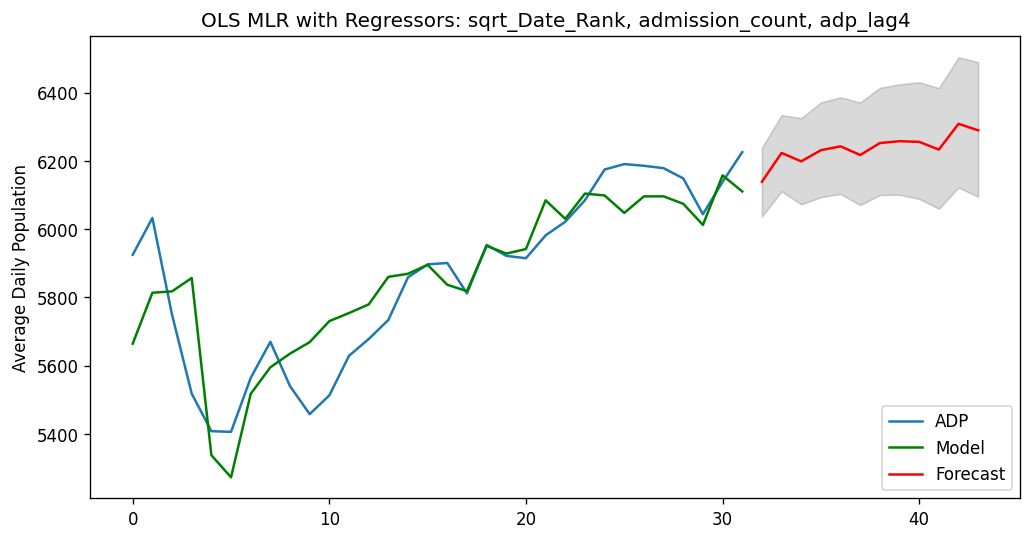

6289.861581086067 6095.166528561807 6489.705367809764


In [111]:
#plot model 2
model_fit,IS_pred, fc_12, mae = fit_OLS_feature_selection(_30day_pop_tot[['Start Date', 'End Date', 'ADP']],'sqrt_Date_Rank')

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(_30day_pop_tot.index,_30day_pop_tot['ADP'],label='ADP') # ACTUAL DATA
ax.plot(_30day_pop_tot.index,IS_pred,color='green',label='Model') # MODEL
ax.plot(np.arange(len(ts),len(ts)+12),fc_12,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(np.arange(len(ts),len(ts)+12), lower_bound_m2, upper_bound_m2, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'OLS MLR with Regressors: sqrt_Date_Rank, admission_count, adp_lag4')
plt.legend(loc = 'lower right')
plt.show()

print(fc_12[11], lower_bound_m2[11], upper_bound_m2[11])


|Model Type | IVs | In Sample MAE | Out of Sample MAE | Significance $\alpha$ = 0.05 | Final Prediction Value | 95% CI Lower Bound | 95% CI Upper Bound |
|-----------|-----|---------------|-------------------|------------------------------|------------------------|--------------------|--------------------|
|MLR | ['Date_Rank','adp_lag4','admission_count'] | 72.64 | 55.37 | No| 6,511 | 6,347 | 6,680|
|MLR | ['sqrt_Date_Rank','adp_lag4','admission_count'] | 96.78 | 200.2 | Yes| 6,290 | 6,095 | 6,490|
|ARIMA | (2,1,0) | 311.81 | 37.34 | Yes | 6,188 | 5,517 | 6,859|
|ARIMAX | (2,1,0) & admission_count | 294.24 | 34.19 | Yes| 6,226 | 5,581 | 6,872|